# Get Historic Football Data From Sporting Life

In [292]:
import urllib
import requests
import json
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import pymysql
import sqlalchemy
import sys
import threading
from multiprocessing import Queue, Pool
from bs4 import BeautifulSoup
import ast
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [94]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Get Data From Sporting Lift Site

In [2]:
# matches_data = []
# goals_data = []
# failed_dates = []

In [3]:
past_dates = pd.date_range(start='2014-01-01', end='2022-12-29')

In [4]:
for d in tqdm(past_dates):
    try:
        yyyymmdd = d.strftime('%Y')+'-'+d.strftime('%m')+'-'+d.strftime('%d')
        dateurl = 'https://www.sportinglife.com/football/fixtures-results/'+yyyymmdd
        datejson = urllib.request.urlopen(dateurl).read()
        soup = BeautifulSoup(datejson)
        soup_find = soup.body.find(attrs={"type": "application/json"})
        soup_json = json.loads(soup_find.text)
        
        matches = soup_json.get('props', {}).get('pageProps', {}).get('matches', [])
        for m in matches:
            match_ref = m.get('match_reference', {}).get('id')
            match_date = m.get('match_date')
            match_time = m.get('match_time')

            matches_data.append(
                [
                    match_ref, match_date, match_time,
                    m.get('state'),
                    m.get('match_type'), 
                    m.get('competition', {}).get('competition_reference', {}).get('id'),
                    m.get('competition', {}).get('name'),
                    str(m.get('round')),
                    m.get('legs'),
                    m.get('leg'),
                    m.get('team_score_a', {}).get('team', {}).get('team_reference', {}).get('id'),
                    m.get('team_score_a', {}).get('team', {}).get('name'),
                    m.get('team_score_a', {}).get('team', {}).get('short_name'),
                    m.get('team_score_a', {}).get('score', [])[0].get('score'),
                    m.get('team_score_b', {}).get('team', {}).get('team_reference', {}).get('id'),
                    m.get('team_score_b', {}).get('team', {}).get('name'),
                    m.get('team_score_b', {}).get('team', {}).get('short_name'),
                    m.get('team_score_b', {}).get('score', [])[0].get('score'),
                    m.get('match_outcome', {}).get('outcome'),
                    m.get('match_outcome', {}).get('result_type'),
                    m.get('match_outcome', {}).get('winner', {}).get('team_reference', {}).get('id'),
                    m.get('match_outcome', {}).get('winner', {}).get('name'),
                    m.get('match_outcome', {}).get('winner', {}).get('short_name'),
                    m.get('half_time_score', {}).get('home'),
                    m.get('half_time_score', {}).get('away'),
                    m.get('full_time_score', {}).get('home'),
                    m.get('full_time_score', {}).get('away'),
                    m.get('clock')
                ]
            )

            homegoals = m.get('homeGoals', [])
            for g in homegoals:
                player = g.get('team_player')
                goal_id = g.get('id')
                for goal in g.get('goal', []):
                    goals_data.append(
                        [
                            match_ref, match_date, match_time,
                            player, goal_id,
                            goal.get('type'),
                            goal.get('time'),
                            goal.get('event_id'),
                            goal.get('event_time'),
                            'home'
                        ]
                    )

            awaygoals = m.get('awayGoals', [])
            for g in awaygoals:
                player = g.get('team_player')
                goal_id = g.get('id')
                for goal in g.get('goal', []):
                    goals_data.append(
                        [
                            match_ref, match_date, match_time,
                            player, goal_id,
                            goal.get('type'),
                            goal.get('time'),
                            goal.get('event_id'),
                            goal.get('event_time'),
                            'away'
                        ]
                    )
        
    except:
        failed_dates.append(d)

100%|██████████| 3285/3285 [27:26<00:00,  2.00it/s]


In [5]:
matches_cols = [
    'match_ref', 'match_date', 'match_time', 'state', 'match_type', 'competition_id', 'competition_name', 
    'round', 'legs', 'leg', 'team_a_id', 'team_a_name', 'team_a_short_name', 'team_a_score',
    'team_b_id', 'team_b_name', 'team_b_short_name', 'team_b_score',
    'outcome', 'result_type', 'winner_id', 'winner_name', 'winner_short_name',
    'half_time_score_home', 'half_time_score_away',
    'full_time_score_home', 'full_time_score_away', 'clock'
]
matches_df = pd.DataFrame(matches_data, columns=matches_cols)

In [6]:
goals_cols = [
    'match_ref', 'match_date', 'match_time', 'player', 'goal_id', 'type', 'time', 'event_id', 'event_time', 'side'
]
goals_df = pd.DataFrame(goals_data, columns=goals_cols)

In [7]:
def get_extra_time(t):
    time_split = t.replace("'", "").split("+")
    if len(time_split)>1:
        return int(time_split[1])
    else:
        return 0

goals_df['time_regular'] = goals_df['time'].apply(lambda x: int(x.replace("'", "").split("+")[0]))
goals_df['time_extra'] = goals_df['time'].apply(get_extra_time)

In [8]:
matches_df.tail(3)

,match_ref,match_date,match_time,state,match_type,competition_id,competition_name,round,legs,leg,...,outcome,result_type,winner_id,winner_name,winner_short_name,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,clock
93929,147830,2022-12-29T20:15:00.000Z,20:15,FULLTIME,Regular,10,Sky Bet Championship,{},1,1,...,WIN,NORMALRESULT,310.0,Sheffield United,Sheffield Utd,0.0,1.0,1.0,2.0,FT
93930,149640,2022-12-29T20:30:00.000Z,20:30,FULLTIME,Regular,74,Spanish La Liga,{},1,1,...,WIN,NORMALRESULT,51.0,Atlético de Madrid,Atlético de Madrid,0.0,0.0,2.0,0.0,FT
93931,151232,2022-12-29T21:15:00.000Z,21:15,FULLTIME,Regular,14,Portuguese Primeira Liga,{},1,1,...,WIN,NORMALRESULT,42.0,Sporting CP,Sporting,3.0,0.0,3.0,0.0,FT


In [9]:
goals_df.tail(3)

,match_ref,match_date,match_time,player,goal_id,type,time,event_id,event_time,side,time_regular,time_extra
179273,151232,2022-12-29T21:15:00.000Z,21:15,Nuno Santos,7462,10,22',11641543,2022-12-29T21:38:32.000Z,home,22,0
179274,151232,2022-12-29T21:15:00.000Z,21:15,Paulinho,34141,10,44',11642060,2022-12-29T22:01:07.000Z,home,44,0
179275,151232,2022-12-29T21:15:00.000Z,21:15,Pedro Porro,50000,10,3',11640291,2022-12-29T21:19:15.000Z,home,3,0


In [10]:
matches_df.shape

(93932, 28)

In [11]:
goals_df.shape

(179276, 12)

In [12]:
matches_df.groupby('competition_name').size().sort_values()

competition_name
UEFA Super Cup                        6
English Community Shield              8
Olympic Women's Tournament           26
International Champions Cup          29
Scottish Championship Play-offs      32
                                   ... 
Sky Bet League Two                 3052
English National League            3058
US Major League Soccer             3462
Sky Bet League One                 3755
Sky Bet Championship               4243
Length: 82, dtype: int64

# EDA

In [13]:
matches_df.describe()

,match_ref,competition_id,legs,leg,team_a_id,team_a_score,team_b_id,team_b_score,winner_id,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away
count,93932.000000,93932.000000,93932.0,93932.0,93932.000000,93932.000000,93932.000000,93932.000000,71832.000000,87185.000000,87185.000000,87185.000000,87185.000000
mean,80553.080218,43.518599,1.0,1.0,816.674371,1.447057,816.101105,1.170911,764.854188,0.633641,0.507564,1.545186,1.250123
std,45082.840491,31.560867,0.0,0.0,771.292329,1.366610,766.379512,1.223944,744.548190,0.836086,0.751026,1.354341,1.221756
min,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,46109.750000,14.000000,1.0,1.0,216.000000,0.000000,216.000000,0.000000,186.000000,0.000000,0.000000,1.000000,0.000000
50%,82198.500000,43.000000,1.0,1.0,664.000000,1.000000,665.000000,1.000000,644.000000,0.000000,0.000000,1.000000,1.000000
75%,118584.250000,69.000000,1.0,1.0,1086.000000,2.000000,1087.000000,2.000000,996.000000,1.000000,1.000000,2.000000,2.000000
max,159739.000000,194.000000,1.0,1.0,4174.000000,20.000000,4194.000000,15.000000,4194.000000,11.000000,11.000000,20.000000,15.000000


In [14]:
matches_df.isnull().sum(axis=0)

match_ref                   0
match_date                  0
match_time                  0
state                       0
match_type                  4
competition_id              0
competition_name            0
round                       0
legs                        0
leg                         0
team_a_id                   0
team_a_name                 0
team_a_short_name       25101
team_a_score                0
team_b_id                   0
team_b_name                 0
team_b_short_name       25083
team_b_score                0
outcome                  1378
result_type              6619
winner_id               22100
winner_name             22100
winner_short_name       39432
half_time_score_home     6747
half_time_score_away     6747
full_time_score_home     6747
full_time_score_away     6747
clock                   29234
dtype: int64

In [15]:
matches_df['match_ref'].nunique()

93932

In [16]:
goals_df.describe()

,match_ref,time_regular,time_extra
count,179276.000000,179276.000000,179276.000000
mean,90681.425088,50.354320,0.214959
std,41360.172813,26.622986,0.926208
min,19.000000,0.000000,0.000000
25%,61797.000000,28.000000,0.000000
50%,90775.500000,51.000000,0.000000
75%,126687.000000,73.000000,0.000000
max,159232.000000,120.000000,21.000000


In [17]:
goals_df.isnull().sum(axis=0)

match_ref       0
match_date      0
match_time      0
player          0
goal_id         0
type            0
time            0
event_id        0
event_time      0
side            0
time_regular    0
time_extra      0
dtype: int64

In [18]:
goals_df['match_ref'].nunique()

60460

In [19]:
matches_df['year'] = matches_df['match_date'].apply(lambda x: x[:4])

In [21]:
competition_match_counts = matches_df.groupby('competition_name').agg({
    'match_ref': len,
}).reset_index().rename(columns={'match_ref': 'matches'})

In [22]:
comp_year_match_count = matches_df.groupby(['competition_name', 'year']).size().reset_index()

In [24]:
pd.options.display.max_rows = 100
comp_year_match_count[comp_year_match_count['competition_name'].isin(
    competition_match_counts.sort_values('matches').tail(10)['competition_name'])]

,competition_name,year,0
144,English National League,2014,1
145,English National League,2016,251
146,English National League,2017,396
147,English National League,2018,357
148,English National League,2019,566
149,English National League,2020,374
150,English National League,2021,552
151,English National League,2022,561
152,English National North,2014,156
153,English National North,2015,301


In [29]:
goals_df_with_comps = goals_df.merge(matches_df[['match_ref', 'competition_name']], how='inner', on='match_ref')
goals_df_with_comps['year'] = goals_df_with_comps['match_date'].apply(lambda x: x[:4])

In [30]:
comp_year_goal_count = goals_df_with_comps.groupby(['competition_name', 'year']).size().reset_index()

In [31]:
comp_year_goal_count[comp_year_goal_count['competition_name'].isin(
    competition_match_counts.sort_values('matches').tail(10)['competition_name'])]

,competition_name,year,0
107,English National League,2014,1
108,English National League,2016,74
109,English National League,2017,1062
110,English National League,2018,833
111,English National League,2019,1484
112,English National League,2020,737
113,English National League,2021,1513
114,English National League,2022,1572
115,English National North,2017,12
116,English National North,2018,792


Goals data seems to start in 2017

# First Feature Generation

In [181]:
goals_df.head(10)

,match_ref,match_date,match_time,player,goal_id,type,time,event_id,event_time,side,time_regular,time_extra,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,goals_35m_to_40m,goals_post_40m,goals_pre_45m,goals_40m_to_45m,goals_post_45m,goals_pre_50m,goals_45m_to_50m,goals_post_50m,goals_pre_55m,goals_50m_to_55m,goals_post_55m,goals_pre_60m,goals_55m_to_60m,goals_post_60m,goals_pre_65m,goals_60m_to_65m,goals_post_65m,goals_pre_70m,goals_65m_to_70m,goals_post_70m,goals_pre_75m,goals_70m_to_75m,goals_post_75m,goals_pre_80m,goals_75m_to_80m,goals_post_80m,goals_pre_85m,goals_80m_to_85m,goals_post_85m,goals_pre_90m,goals_85m_to_90m,goals_post_90m
0,26370,2014-01-01T15:00:00.000Z,15:00,Connor Wickham,2313,10,50',11576728,2022-12-13T06:56:49.000Z,home,50,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,26370,2014-01-01T15:00:00.000Z,15:00,Chris Maguire,5832,10,60',11576731,2022-12-13T06:56:49.000Z,home,60,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,54239,2014-01-01T15:00:00.000Z,15:00,Jason Puncheon,2310,12,44',2963762,2018-09-12T14:08:19.000Z,home,44,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,54239,2014-01-01T15:00:00.000Z,15:00,Bradley Johnson,1153,10,39',2963761,2018-09-12T14:08:19.000Z,away,39,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,29450,2014-01-05T14:15:00.000Z,14:15,Oscar,114,10,71',2107397,2018-02-13T15:27:26.277Z,away,71,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0
5,29450,2014-01-05T14:15:00.000Z,14:15,John Obi Mikel,2474,10,66',2107398,2018-02-13T15:27:26.465Z,away,66,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0
6,68390,2014-01-07T15:30:00.000Z,15:30,Bas Dost,953,12,83',2963047,2018-09-12T13:50:52.000Z,home,83,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0
7,68390,2014-01-07T15:30:00.000Z,15:30,Bas Dost,953,10,86',2963048,2018-09-12T13:50:52.000Z,home,86,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0
8,68390,2014-01-07T15:30:00.000Z,15:30,Lucas Piazon,4234,10,35',2963045,2018-09-12T13:50:52.000Z,away,35,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
9,68390,2014-01-07T15:30:00.000Z,15:30,Mike Havenaar,8451,10,28',2963044,2018-09-12T13:50:52.000Z,away,28,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0


In [205]:
time_cutoffs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
cap_at = 90
time_features = []
for i, t in enumerate(time_cutoffs):
    goals_df[f'goals_pre_{t}m'] = ((goals_df[f'time_regular']<t) & (goals_df[f'time_regular']<=cap_at))*1
    time_features += [f'goals_pre_{t}m']
    if t > min(time_cutoffs):
        goals_df[f'goals_{time_cutoffs[i-1]}m_to_{t}m'] = (
            goals_df[f'goals_pre_{t}m'] - goals_df[f'goals_pre_{time_cutoffs[i-1]}m'])
        time_features += [f'goals_{time_cutoffs[i-1]}m_to_{t}m']
    
    goals_df[f'goals_post_{t}m'] = ((goals_df[f'time_regular']>=t) & (goals_df[f'time_regular']<=cap_at))*1
    time_features += [f'goals_post_{t}m']

# same for home and away goals
time_features_home_away = []
for i, t in enumerate(time_cutoffs):
    goals_df[f'home_goals_pre_{t}m'] = ((goals_df[f'time_regular']<t) & (goals_df[f'time_regular']<=cap_at) & (goals_df[f'side']=='home'))*1
    time_features_home_away += [f'home_goals_pre_{t}m']
    
    goals_df[f'away_goals_pre_{t}m'] = ((goals_df[f'time_regular']<t) & (goals_df[f'time_regular']<=cap_at) & (goals_df[f'side']=='away'))*1
    time_features_home_away += [f'away_goals_pre_{t}m']
    
    if t > min(time_cutoffs):
        goals_df[f'home_goals_{time_cutoffs[i-1]}m_to_{t}m'] = (
            goals_df[f'home_goals_pre_{t}m'] - goals_df[f'home_goals_pre_{time_cutoffs[i-1]}m'])
        time_features_home_away += [f'home_goals_{time_cutoffs[i-1]}m_to_{t}m']
        
        goals_df[f'away_goals_{time_cutoffs[i-1]}m_to_{t}m'] = (
            goals_df[f'away_goals_pre_{t}m'] - goals_df[f'away_goals_pre_{time_cutoffs[i-1]}m'])
        time_features_home_away += [f'away_goals_{time_cutoffs[i-1]}m_to_{t}m']
    
    goals_df[f'home_goals_post_{t}m'] = ((goals_df[f'time_regular']>=t) & (goals_df[f'time_regular']<=cap_at) & (goals_df[f'side']=='home'))*1
    time_features_home_away += [f'home_goals_post_{t}m']
    
    goals_df[f'away_goals_post_{t}m'] = ((goals_df[f'time_regular']>=t) & (goals_df[f'time_regular']<=cap_at) & (goals_df[f'side']=='away'))*1
    time_features_home_away += [f'away_goals_post_{t}m']

In [206]:
goals_features = goals_df.groupby(['match_ref', 'match_date'])[time_features+time_features_home_away].sum().reset_index()

In [207]:
model_data = matches_df.merge(goals_features, how='left', on=['match_ref', 'match_date'])

for f in time_features + time_features_home_away:
    model_data[f] = model_data[f].fillna(0)
    
for t in time_cutoffs:
    model_data[f'goal_diff_at_{t}'] = model_data[f'home_goals_pre_{t}m'] - model_data[f'away_goals_pre_{t}m']
    model_data[f'abs_goal_diff_at_{t}'] = abs(model_data[f'goal_diff_at_{t}'])

In [208]:
# check only include games with no goals data if score is 0 - 0
model_data['goals_data_num_goals'] = model_data['goals_pre_90m'] + model_data['goals_post_90m']
model_data['matches_data_num_goals'] = model_data['team_a_score'] + model_data['team_b_score']

In [209]:
model_data_no_goals_data = model_data[(model_data['goals_data_num_goals']==0) & (model_data['matches_data_num_goals']>0)]
model_data = model_data[~((model_data['goals_data_num_goals']==0) & (model_data['matches_data_num_goals']>0))]

In [210]:
model_data_no_goals_data.shape

(21384, 226)

In [211]:
model_data.shape

(72548, 226)

In [212]:
sum(model_data['goals_data_num_goals'] != model_data['matches_data_num_goals'])

1532

In [213]:
model_data[model_data['goals_data_num_goals'] != model_data['matches_data_num_goals']].tail(50)

,match_ref,match_date,match_time,state,match_type,competition_id,competition_name,round,legs,leg,team_a_id,team_a_name,team_a_short_name,team_a_score,team_b_id,team_b_name,team_b_short_name,team_b_score,outcome,result_type,winner_id,winner_name,winner_short_name,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,clock,year,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,...,home_goals_pre_85m,away_goals_pre_85m,home_goals_80m_to_85m,away_goals_80m_to_85m,home_goals_post_85m,away_goals_post_85m,home_goals_pre_90m,away_goals_pre_90m,home_goals_85m_to_90m,away_goals_85m_to_90m,home_goals_post_90m,away_goals_post_90m,goal_diff_at_5,abs_goal_diff_at_5,goal_diff_at_10,abs_goal_diff_at_10,goal_diff_at_15,abs_goal_diff_at_15,goal_diff_at_20,abs_goal_diff_at_20,goal_diff_at_25,abs_goal_diff_at_25,goal_diff_at_30,abs_goal_diff_at_30,goal_diff_at_35,abs_goal_diff_at_35,goal_diff_at_40,abs_goal_diff_at_40,goal_diff_at_45,abs_goal_diff_at_45,goal_diff_at_50,abs_goal_diff_at_50,goal_diff_at_55,abs_goal_diff_at_55,goal_diff_at_60,abs_goal_diff_at_60,goal_diff_at_65,abs_goal_diff_at_65,goal_diff_at_70,abs_goal_diff_at_70,goal_diff_at_75,abs_goal_diff_at_75,goal_diff_at_80,abs_goal_diff_at_80,goal_diff_at_85,abs_goal_diff_at_85,goal_diff_at_90,abs_goal_diff_at_90,goals_data_num_goals,matches_data_num_goals
86802,144514,2022-07-28T18:00:00.000Z,18:00,FULLTIME,SecondLeg,157,UEFA Europa Conference League Qualifying,"{'round_number': 2, 'round_type': 'Round'}",1,1,639,FC Vaduz,None,1,2843,FC Koper,None,1,WIN,AGGREGATE,639.0,FC Vaduz,None,0.0,0.0,0.0,1.0,AET,2022,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,2
86841,143036,2022-07-30T13:31:00.000Z,13:31,FULLTIME,Cup,56,German DFB Pokal,"{'round_number': 1, 'round_type': 'Round'}",1,1,3501,SpVgg Bayreuth,None,1,234,Hamburger SV,Hamburger SV,3,WIN,AFTEREXTRATIME,234.0,Hamburger SV,Hamburger SV,1.0,0.0,1.0,1.0,AET,2022,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,4
86953,143015,2022-07-31T13:31:00.000Z,13:31,FULLTIME,Cup,56,German DFB Pokal,"{'round_number': 1, 'round_type': 'Round'}",1,1,1013,1. FC Kaiserslautern,1. FC K'lautern,1,239,SC Freiburg,Freiburg,2,WIN,AFTEREXTRATIME,239.0,SC Freiburg,Freiburg,1.0,0.0,1.0,1.0,AET,2022,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3
86969,147143,2022-07-31T16:00:00.000Z,16:00,FULLTIME,Cup,194,UEFA Women's Championship,"{'round_number': 4, 'round_type': 'Final'}",1,1,358,England Women,England,2,355,Germany Women,Germany,1,WIN,AFTEREXTRATIME,358.0,England Women,England,0.0,0.0,1.0,1.0,AET,2022,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3
86973,143017,2022-07-31T16:01:00.000Z,16:01,FULLTIME,Cup,56,German DFB Pokal,"{'round_number': 1, 'round_type': 'Round'}",1,1,1088,Eintracht Braunschweig,Eintracht Braunschweig,4,237,Hertha BSC

In [214]:
model_data = model_data[model_data['goals_data_num_goals'] == model_data['matches_data_num_goals']]

In [215]:
model_data.shape

(71016, 226)

In [216]:
pd.options.display.max_rows = 300
model_data.isnull().sum(axis=0)

match_ref                     0
match_date                    0
match_time                    0
state                         0
match_type                    4
competition_id                0
competition_name              0
round                         0
legs                          0
leg                           0
team_a_id                     0
team_a_name                   0
team_a_short_name         15913
team_a_score                  0
team_b_id                     0
team_b_name                   0
team_b_short_name         15808
team_b_score                  0
outcome                    1378
result_type                6599
winner_id                 18327
winner_name               18327
winner_short_name         28495
half_time_score_home       6709
half_time_score_away       6709
full_time_score_home       6709
full_time_score_away       6709
clock                      9006
year                          0
goals_pre_5m                  0
goals_post_5m                 0
goals_pr

In [217]:
model_data = model_data[model_data['half_time_score_home'].notnull()]

In [218]:
model_data['any_goal_post_50'] = (model_data['goals_post_50m']>0)*1
model_data['any_goal_post_60'] = (model_data['goals_post_60m']>0)*1
model_data['any_goal_post_70'] = (model_data['goals_post_70m']>0)*1
model_data['any_goal_post_75'] = (model_data['goals_post_75m']>0)*1
model_data['any_goal_post_80'] = (model_data['goals_post_80m']>0)*1
model_data['any_goal_post_85'] = (model_data['goals_post_85m']>0)*1

In [219]:
model_data['total_goals'] = model_data['team_a_score'] + model_data['team_b_score']
model_data['score_diff'] = model_data['team_a_score'] - model_data['team_b_score']
model_data['score_diff_abs'] = abs(model_data['score_diff'])

# First Stats

In [220]:
model_data.describe()

,match_ref,competition_id,legs,leg,team_a_id,team_a_score,team_b_id,team_b_score,winner_id,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,goals_35m_to_40m,goals_post_40m,goals_pre_45m,goals_40m_to_45m,goals_post_45m,goals_pre_50m,goals_45m_to_50m,goals_post_50m,goals_pre_55m,goals_50m_to_55m,goals_post_55m,goals_pre_60m,goals_55m_to_60m,goals_post_60m,goals_pre_65m,goals_60m_to_65m,...,away_goals_85m_to_90m,home_goals_post_90m,away_goals_post_90m,goal_diff_at_5,abs_goal_diff_at_5,goal_diff_at_10,abs_goal_diff_at_10,goal_diff_at_15,abs_goal_diff_at_15,goal_diff_at_20,abs_goal_diff_at_20,goal_diff_at_25,abs_goal_diff_at_25,goal_diff_at_30,abs_goal_diff_at_30,goal_diff_at_35,abs_goal_diff_at_35,goal_diff_at_40,abs_goal_diff_at_40,goal_diff_at_45,abs_goal_diff_at_45,goal_diff_at_50,abs_goal_diff_at_50,goal_diff_at_55,abs_goal_diff_at_55,goal_diff_at_60,abs_goal_diff_at_60,goal_diff_at_65,abs_goal_diff_at_65,goal_diff_at_70,abs_goal_diff_at_70,goal_diff_at_75,abs_goal_diff_at_75,goal_diff_at_80,abs_goal_diff_at_80,goal_diff_at_85,abs_goal_diff_at_85,goal_diff_at_90,abs_goal_diff_at_90,goals_data_num_goals,matches_data_num_goals,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85,total_goals,score_diff,score_diff_abs
count,64307.000000,64307.000000,64307.0,64307.0,64307.000000,64307.000000,64307.000000,64307.000000,48597.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,...,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000,64307.000000
mean,90657.003670,41.565599,1.0,1.0,784.739702,1.482140,783.195749,1.211066,731.416775,0.660566,0.536551,1.482949,1.211921,0.074269,2.618937,0.196650,0.122382,2.496556,0.323137,0.126487,2.370069,0.450931,0.127793,2.242275,0.580497,0.129566,2.112709,0.711462,0.130966,1.981744,0.843952,0.132489,1.849254,0.976612,0.132661,1.716594,1.113269,0.136657,1.579937,1.297122,0.183852,1.396084,1.452610,0.155489,1.240596,1.607197,0.154587,1.086009,1.758269,0.151072,...,0.069370,0.098403,0.083350,0.010605,0.072651,0.024850,0.182904,0.038285,0.285288,0.049512,0.379212,0.062326,0.466512,0.075108,0.547903,0.089166,0.624878,0.102835,0.695741,0.116581,0.765686,0.137341,0.849301,0.151259,0.917272,0.170619,0.985834,0.187740,1.044474,0.201393,1.101824,0.214611,1.156655,0.225994,1.209837,0.242244,1.264341,0.255742,1.317741,2.693206,2.693206,0.748223,0.663536,0.548027,0.478051,0.392694,0.290388,2.693206,0.271075,1.371142
std,41337.705314,30.918426,0.0,0.0,763.920746,1.327972,757.276647,1.205273,729.053160,0.841632,0.764404,1.327936,1.205555,0.267727,1.696331,0.433834,0.34139

In [221]:
model_data[model_data['competition_name']=='English Premier League'].describe()

,match_ref,competition_id,legs,leg,team_a_id,team_a_score,team_b_id,team_b_score,winner_id,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,goals_35m_to_40m,goals_post_40m,goals_pre_45m,goals_40m_to_45m,goals_post_45m,goals_pre_50m,goals_45m_to_50m,goals_post_50m,goals_pre_55m,goals_50m_to_55m,goals_post_55m,goals_pre_60m,goals_55m_to_60m,goals_post_60m,goals_pre_65m,goals_60m_to_65m,...,away_goals_85m_to_90m,home_goals_post_90m,away_goals_post_90m,goal_diff_at_5,abs_goal_diff_at_5,goal_diff_at_10,abs_goal_diff_at_10,goal_diff_at_15,abs_goal_diff_at_15,goal_diff_at_20,abs_goal_diff_at_20,goal_diff_at_25,abs_goal_diff_at_25,goal_diff_at_30,abs_goal_diff_at_30,goal_diff_at_35,abs_goal_diff_at_35,goal_diff_at_40,abs_goal_diff_at_40,goal_diff_at_45,abs_goal_diff_at_45,goal_diff_at_50,abs_goal_diff_at_50,goal_diff_at_55,abs_goal_diff_at_55,goal_diff_at_60,abs_goal_diff_at_60,goal_diff_at_65,abs_goal_diff_at_65,goal_diff_at_70,abs_goal_diff_at_70,goal_diff_at_75,abs_goal_diff_at_75,goal_diff_at_80,abs_goal_diff_at_80,goal_diff_at_85,abs_goal_diff_at_85,goal_diff_at_90,abs_goal_diff_at_90,goals_data_num_goals,matches_data_num_goals,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85,total_goals,score_diff,score_diff_abs
count,2020.000000,2020.0,2020.0,2020.0,2020.000000,2020.000000,2020.000000,2020.000000,1527.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,...,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.00000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000
mean,82716.449010,1.0,1.0,1.0,67.388614,1.463861,67.345545,1.217822,54.620170,0.665347,0.554455,1.463861,1.217822,0.071782,2.609901,0.197525,0.125743,2.484158,0.322277,0.124752,2.359406,0.444059,0.121782,2.237624,0.579703,0.135644,2.101980,0.708416,0.128713,1.973267,0.851485,0.143069,1.830198,0.973267,0.121782,1.708416,1.123762,0.150495,1.557921,1.315842,0.192079,1.365842,1.468317,0.152475,1.213366,1.623267,0.154950,1.058416,1.766337,0.143069,...,0.058911,0.098020,0.091089,0.011386,0.069802,0.015347,0.182673,0.021287,0.284653,0.042079,0.371782,0.050000,0.467822,0.062871,0.54505,0.068317,0.624752,0.087129,0.696040,0.106931,0.782178,0.133663,0.871287,0.143564,0.929703,0.160891,1.009406,0.165347,1.071287,0.179208,1.131683,0.176733,1.191584,0.198515,1.246040,0.223762,1.309901,0.239109,1.358911,2.681683,2.681683,0.744059,0.657921,0.546040,0.468812,0.383663,0.285644,2.681683,0.246040,1.434158
std,41945.907027,0.0,0.0,0.0,94.310212,1.323832,94.270607,1.212891,86.547344,0.847387,0.774472,1.323832,1.212891,0.263883,1.647879,0.432798,0.344820,1.609545,0.557358,0.346612,1.559307,0.658197,0.347667,1.509413,0.750159,0.351064,1.456823,0.820508,0.346592,1.399171,0.9142

In [222]:
model_data[model_data['goals_pre_80m']==2].describe()

,match_ref,competition_id,legs,leg,team_a_id,team_a_score,team_b_id,team_b_score,winner_id,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,goals_35m_to_40m,goals_post_40m,goals_pre_45m,goals_40m_to_45m,goals_post_45m,goals_pre_50m,goals_45m_to_50m,goals_post_50m,goals_pre_55m,goals_50m_to_55m,goals_post_55m,goals_pre_60m,goals_55m_to_60m,goals_post_60m,goals_pre_65m,goals_60m_to_65m,...,away_goals_85m_to_90m,home_goals_post_90m,away_goals_post_90m,goal_diff_at_5,abs_goal_diff_at_5,goal_diff_at_10,abs_goal_diff_at_10,goal_diff_at_15,abs_goal_diff_at_15,goal_diff_at_20,abs_goal_diff_at_20,goal_diff_at_25,abs_goal_diff_at_25,goal_diff_at_30,abs_goal_diff_at_30,goal_diff_at_35,abs_goal_diff_at_35,goal_diff_at_40,abs_goal_diff_at_40,goal_diff_at_45,abs_goal_diff_at_45,goal_diff_at_50,abs_goal_diff_at_50,goal_diff_at_55,abs_goal_diff_at_55,goal_diff_at_60,abs_goal_diff_at_60,goal_diff_at_65,abs_goal_diff_at_65,goal_diff_at_70,abs_goal_diff_at_70,goal_diff_at_75,abs_goal_diff_at_75,goal_diff_at_80,abs_goal_diff_at_80,goal_diff_at_85,abs_goal_diff_at_85,goal_diff_at_90,abs_goal_diff_at_90,goals_data_num_goals,matches_data_num_goals,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85,total_goals,score_diff,score_diff_abs
count,16405.000000,16405.000000,16405.0,16405.0,16405.000000,16405.000000,16405.000000,16405.000000,11647.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.00000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,...,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.000000,16405.00000,16405.000000
mean,91494.048217,41.219872,1.0,1.0,768.579275,1.370863,776.036391,1.125632,718.666695,0.598110,0.483450,1.371411,1.126120,0.065895,2.430600,0.174276,0.108382,2.322219,0.290094,0.115818,2.206400,0.406888,0.116794,2.089607,0.523133,0.116245,1.973362,0.641634,0.11850,1.854861,0.759768,0.118135,1.736727,0.881012,0.121244,1.615483,1.008046,0.127034,1.488449,1.171594,0.163548,1.324901,1.317830,0.146236,1.178665,1.456446,0.138616,1.040049,1.593539,0.137092,...,0.067479,0.099848,0.084974,0.009205,0.065163,0.024078,0.168546,0.038220,0.274368,0.049558,0.372996,0.062054,0.464005,0.074124,0.551173,0.088632,0.633709,0.099665,0.707894,0.108321,0.773240,0.130326,0.852789,0.141847,0.915270,0.160500,0.966108,0.174215,0.999329,0.183115,1.025907,0.193965,1.042243,0.201768,1.051996,0.212801,1.135325,0.229991,1.207498,2.496495,2.496495,0.799939,0.688388,0.556416,0.485218,0.404694,0.296800,2.496495,0.24523,1.279183
std,40999.857614,30.719144,0.0,0.0,752.468993,0.899540,750.054830,0.875862,716.972161,0.645891,0.600778,0.899958,0.876488,0.250063,0.718152,0.394638,0.316699,0.

In [223]:
model_data.groupby('goals_pre_80m').agg({'match_ref': len, 'any_goal_post_80': np.mean, 'any_goal_post_85': np.mean})

,match_ref,any_goal_post_80,any_goal_post_85
goals_pre_80m,,,
0.0,8306,0.297857,0.217794
1.0,14905,0.398994,0.300369
2.0,16405,0.404694,0.296800
3.0,12496,0.400928,0.297535
4.0,7012,0.426697,0.311751
5.0,3329,0.413938,0.306098
6.0,1254,0.422648,0.317384
7.0,442,0.459276,0.328054
8.0,108,0.462963,0.296296


In [224]:
model_data.groupby('score_diff').agg({'match_ref': len, 'any_goal_post_80': np.mean, 'any_goal_post_85': np.mean})

,match_ref,any_goal_post_80,any_goal_post_85
score_diff,,,
-14,1,1.000000,1.000000
-13,1,1.000000,1.000000
-12,2,0.500000,0.500000
-11,2,0.500000,0.500000
-10,7,0.714286,0.571429
-9,10,0.900000,0.800000
-8,23,0.826087,0.652174
-7,49,0.795918,0.571429
-6,132,0.636364,0.515152


In [225]:
model_data.head(3)

,match_ref,match_date,match_time,state,match_type,competition_id,competition_name,round,legs,leg,team_a_id,team_a_name,team_a_short_name,team_a_score,team_b_id,team_b_name,team_b_short_name,team_b_score,outcome,result_type,winner_id,winner_name,winner_short_name,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,clock,year,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,...,away_goals_85m_to_90m,home_goals_post_90m,away_goals_post_90m,goal_diff_at_5,abs_goal_diff_at_5,goal_diff_at_10,abs_goal_diff_at_10,goal_diff_at_15,abs_goal_diff_at_15,goal_diff_at_20,abs_goal_diff_at_20,goal_diff_at_25,abs_goal_diff_at_25,goal_diff_at_30,abs_goal_diff_at_30,goal_diff_at_35,abs_goal_diff_at_35,goal_diff_at_40,abs_goal_diff_at_40,goal_diff_at_45,abs_goal_diff_at_45,goal_diff_at_50,abs_goal_diff_at_50,goal_diff_at_55,abs_goal_diff_at_55,goal_diff_at_60,abs_goal_diff_at_60,goal_diff_at_65,abs_goal_diff_at_65,goal_diff_at_70,abs_goal_diff_at_70,goal_diff_at_75,abs_goal_diff_at_75,goal_diff_at_80,abs_goal_diff_at_80,goal_diff_at_85,abs_goal_diff_at_85,goal_diff_at_90,abs_goal_diff_at_90,goals_data_num_goals,matches_data_num_goals,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85,total_goals,score_diff,score_diff_abs
2,74544,2014-01-01T15:00:00.000Z,15:00,FULLTIME,Regular,16,Sky Bet League One,{},1,1,47,MK Dons,MK Dons,0,873,Colchester United,Colchester,0,DRAW,NORMALRESULT,NaN,None,None,0.0,0.0,0.0,0.0,None,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
9,26370,2014-01-01T15:00:00.000Z,15:00,FULLTIME,Regular,10,Sky Bet Championship,{},1,1,221,Sheffield Wednesday,Sheffield Wed,2,941,Blackpool,Blackpool,0,WIN,NORMALRESULT,221.0,Sheffield Wednesday,Sheffield Wed,0.0,0.0,2.0,0.0,None,2014,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,1,1,0,0,0,0,2,2,2
20,54239,2014-01-01T15:00:00.000Z,15:00,FULLTIME,Regular,1,English Premier League,{},1,1,3,Crystal Palace,C Palace,1,212,Norwich City,Norwich,1,DRAW,NORMALRESULT,NaN,None,None,1.0,1.0,1.0,1.0,None,2014,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,0,0,0,0,0,0,2,0,0


In [226]:
model_data.groupby(['home_goals_pre_80m', 'away_goals_pre_80m']).agg({'match_ref': len, 'any_goal_post_80': np.mean, 'any_goal_post_85': np.mean})

match_ref  any_goal_post_80  \
home_goals_pre_80m away_goals_pre_80m                                
0.0                0.0                      8306          0.297857   
                   1.0                      6725          0.403569   
                   2.0                      3487          0.407514   
                   3.0                      1423          0.406887   
                   4.0                       512          0.425781   
                   5.0                       162          0.425926   
                   6.0                        68          0.338235   
                   7.0                        28          0.642857   
                   8.0                         6          0.500000   
                   9.0                         4          0.750000   
                   10.0                        4          0.500000   
                   11.0                        1          0.000000   
                   12.0                        2          0.500000   
1.0                0.0                      8180          0.395232   
                   1.0                      7776          0.398277   
                   2.0                      3954          0.406930   
                   3.0                      1307          0.466718   
                   4.0                       434          0.403226   
                   5.0                       101          0.485149   
                   6.0                        34          0.500000   
                   7.0                        11          0.727273   
                   8.0                         3          1.000000   
                   9.0                         3          0.666667   
2.0                0.0                      5142          0.412485   
                   1.0                      4712          0.396435   
                   2.0                      2266          0.421006   
                   3.0                       791          0.408344   
                   4.0                       204          0.416667   
                   5.0                        44          0.545455   
                   6.0                         7          0.285714   
                   7.0                         1          1.000000   
                   9.0                         1          1.000000   
3.0                0.0                      2407          0.396344   
                   1.0                      1934          0.409514   
                   2.0                       933          0.408360   
                   3.0                       275          0.421818   
                   4.0                        78          0.461538   
                   5.0                        12          0.500000   
                   6.0                         3          0.333333   
                   7.0                         1          1.000000   
4.0                0.0                       993          0.420947   
                   1.0                       678          0.429204   
                   2.0                       294          0.431973   
                   3.0                        83          0.361446   
                   4.0                        18          0.388889   
                   5.0                         4          0.500000   
5.0                0.0                       331          0.419940   
                   1.0                       213          0.417840   
                   2.0                        83          0.433735   
                   3.0                        16          0.375000   
                   4.0                         2          1.000000   
                   5.0                         1          0.000000   
6.0                0.0                        99          0.414141   
                   1.0                        47          0.382979   
                   2.0                        14          0.500000   
                   3.0                         3 

Seems like very similar rates of post 80m and post 85m goals regardless of league and number of goals in the game before that.

Find all the post 80/85 minute goals for all competitions and then look at per year/month changes over time

#### Competition breakdown

In [229]:
competition_stats = model_data.groupby('competition_name').agg({
    'match_ref': len,
    'total_goals': np.mean,
    'score_diff_abs': np.mean,
    'goals_post_50m': np.mean,
    'goals_post_60m': np.mean,
    'goals_post_70m': np.mean,
    'goals_post_75m': np.mean,
    'goals_post_80m': np.mean,
    'goals_post_85m': np.mean,
    'any_goal_post_50': np.mean,
    'any_goal_post_60': np.mean,
    'any_goal_post_70': np.mean,
    'any_goal_post_75': np.mean,
    'any_goal_post_80': np.mean,
    'any_goal_post_85': np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

In [230]:
competition_stats.sort_values('matches', ascending=False)

,competition_name,matches,total_goals,score_diff_abs,goals_post_50m,goals_post_60m,goals_post_70m,goals_post_75m,goals_post_80m,goals_post_85m,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85
52,Sky Bet Championship,3012,2.450531,1.194887,1.287185,1.012948,0.731076,0.588313,0.444887,0.296481,0.722776,0.642098,0.523240,0.447543,0.361886,0.256972
53,Sky Bet League One,2791,2.560014,1.229308,1.312433,1.018990,0.732354,0.593336,0.454676,0.312433,0.732354,0.639197,0.523110,0.456826,0.371193,0.274095
54,Sky Bet League Two,2716,2.467968,1.201399,1.261414,0.983432,0.705449,0.578056,0.436672,0.301546,0.721649,0.634757,0.510677,0.443667,0.359720,0.263255
20,English National League,2627,2.661972,1.299962,1.370765,1.071184,0.785306,0.633803,0.491054,0.350209,0.751427,0.668443,0.555386,0.479254,0.398553,0.304149
75,US Major League Soccer,2309,2.859246,1.308792,1.492854,1.148982,0.827631,0.663491,0.511910,0.355565,0.779125,0.684279,0.566479,0.493720,0.407103,0.307059
34,Italian Serie B,2191,2.314012,1.054313,1.160201,0.895482,0.648106,0.532177,0.416248,0.298037,0.680968,0.592880,0.479233,0.414879,0.344135,0.260612
33,Italian Serie A,2069,2.789270,1.313195,1.459642,1.119865,0.794587,0.634123,0.479942,0.335911,0.764137,0.684872,0.560174,0.482842,0.391010,0.294345
23,English Premier League,2020,2.681683,1.434158,1.365842,1.058416,0.756931,0.613861,0.477228,0.322277,0.744059,0.657921,0.546040,0.468812,0.383663,0.285644
56,Spanish La Liga,1966,2.511190,1.257884,1.326043,1.050865,0.765005,0.640387,0.481689,0.335198,0.738047,0.658698,0.536623,0.476602,0.388098,0.292981
26,French Ligue 1,1946,2.651079,1.319116,1.389517,1.088386,0.776978,0.629496,0.485098,0.320144,0.749743,0.669579,0.546763,0.480473,0.398253,0.283145


Test distribution of p-values under assumption that all leagues have the same probability of post 80m goals

In [231]:
global_mean = np.mean(model_data['any_goal_post_80'])
competition_stats['post_80_goal_p_val'] = [
    1 - sps.binom.cdf(round(m*p - 1), m, global_mean)
    for m, p
    in zip(competition_stats['matches'], competition_stats['any_goal_post_80'])
]


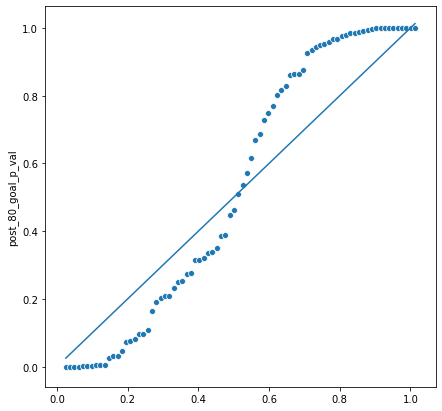

In [232]:
post_80_p_vals = competition_stats.sort_values('post_80_goal_p_val')['post_80_goal_p_val']
h0_p_vals = np.array(range(len(post_80_p_vals)))/len(post_80_p_vals) + 0.025

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(x=h0_p_vals, y=h0_p_vals)
sns.scatterplot(x=h0_p_vals, y=post_80_p_vals)

Definitely looks like significantly different rates for different competitions 

#### Pattern over time for one league

In [233]:
model_data['year'] = model_data['match_date'].apply(lambda x: x[:4]).astype(int)
model_data['month'] = model_data['match_date'].apply(lambda x: x[5:7]).astype(int)

In [236]:
competition_monthly_stats = model_data.groupby(['competition_name', 'year']).agg({
    'match_ref': len,
    'total_goals': np.mean,
    'score_diff_abs': np.mean,
    'goals_post_50m': np.mean,
    'goals_post_60m': np.mean,
    'goals_post_70m': np.mean,
    'goals_post_75m': np.mean,
    'goals_post_80m': np.mean,
    'goals_post_85m': np.mean,
    'any_goal_post_50': np.mean,
    'any_goal_post_60': np.mean,
    'any_goal_post_70': np.mean,
    'any_goal_post_75': np.mean,
    'any_goal_post_80': np.mean,
    'any_goal_post_85': np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

In [237]:
competition = 'English Premier League'
competition_monthly_stats[competition_monthly_stats['competition_name']==competition].sort_values(['year'])

,competition_name,year,matches,total_goals,score_diff_abs,goals_post_50m,goals_post_60m,goals_post_70m,goals_post_75m,goals_post_80m,goals_post_85m,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85
159,English Premier League,2014,13,0.230769,0.076923,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000
160,English Premier League,2015,30,0.266667,0.133333,0.133333,0.133333,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
161,English Premier League,2016,50,1.820000,0.980000,0.960000,0.720000,0.620000,0.480000,0.420000,0.360000,0.520000,0.440000,0.440000,0.340000,0.320000,0.280000
162,English Premier League,2017,267,2.715356,1.516854,1.411985,1.086142,0.831461,0.659176,0.505618,0.355805,0.737828,0.644195,0.565543,0.468165,0.382022,0.288390
163,English Premier League,2018,206,2.737864,1.407767,1.388350,1.077670,0.757282,0.626214,0.475728,0.334951,0.766990,0.679612,0.572816,0.509709,0.402913,0.315534
164,English Premier League,2019,365,2.810959,1.473973,1.487671,1.164384,0.846575,0.684932,0.534247,0.347945,0.808219,0.717808,0.619178,0.526027,0.421918,0.309589
165,English Premier League,2020,333,2.711712,1.474474,1.372372,1.045045,0.774775,0.633634,0.495495,0.312312,0.768769,0.669670,0.576577,0.504505,0.414414,0.279279
166,English Premier League,2021,408,2.715686,1.436275,1.352941,1.066176,0.710784,0.573529,0.431373,0.286765,0.725490,0.647059,0.495098,0.419118,0.333333,0.254902
167,English Premier League,2022,348,2.841954,1.531609,1.410920,1.083333,0.747126,0.612069,0.491379,0.339080,0.778736,0.695402,0.543103,0.477011,0.410920,0.310345


In [238]:
list(competition_stats.sort_values('matches', ascending=False).head(10)['competition_name'])

['Sky Bet Championship',
 'Sky Bet League One',
 'Sky Bet League Two',
 'English National League',
 'US Major League Soccer',
 'Italian Serie B',
 'Italian Serie A',
 'English Premier League',
 'Spanish La Liga',
 'French Ligue 1']

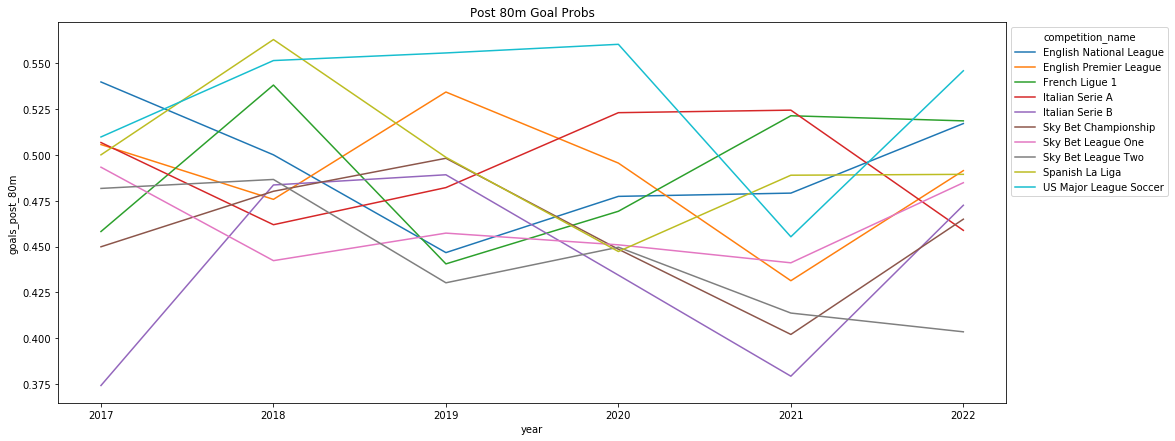

In [239]:
min_year = 2017
comps = list(competition_stats.sort_values('matches', ascending=False).head(10)['competition_name'])
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
sns.lineplot(
    data=competition_monthly_stats[
        (competition_monthly_stats['year']>=min_year) & (competition_monthly_stats['competition_name'].isin(comps))],
    x='year', y='goals_post_80m', hue='competition_name'
).set_title('Post 80m Goal Probs')
plt.legend(bbox_to_anchor=(1, 1))

# Modelling
Can modelling predict a greater disparity of predictions than shown above

In [243]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

In [242]:
list(model_data.columns)

['match_ref',
 'match_date',
 'match_time',
 'state',
 'match_type',
 'competition_id',
 'competition_name',
 'round',
 'legs',
 'leg',
 'team_a_id',
 'team_a_name',
 'team_a_short_name',
 'team_a_score',
 'team_b_id',
 'team_b_name',
 'team_b_short_name',
 'team_b_score',
 'outcome',
 'result_type',
 'winner_id',
 'winner_name',
 'winner_short_name',
 'half_time_score_home',
 'half_time_score_away',
 'full_time_score_home',
 'full_time_score_away',
 'clock',
 'year',
 'goals_pre_5m',
 'goals_post_5m',
 'goals_pre_10m',
 'goals_5m_to_10m',
 'goals_post_10m',
 'goals_pre_15m',
 'goals_10m_to_15m',
 'goals_post_15m',
 'goals_pre_20m',
 'goals_15m_to_20m',
 'goals_post_20m',
 'goals_pre_25m',
 'goals_20m_to_25m',
 'goals_post_25m',
 'goals_pre_30m',
 'goals_25m_to_30m',
 'goals_post_30m',
 'goals_pre_35m',
 'goals_30m_to_35m',
 'goals_post_35m',
 'goals_pre_40m',
 'goals_35m_to_40m',
 'goals_post_40m',
 'goals_pre_45m',
 'goals_40m_to_45m',
 'goals_post_45m',
 'goals_pre_50m',
 'goals_45m

In [252]:
outcome = 'any_goal_post_80'
features = [
    'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'goals_50m_to_55m',
    'goals_55m_to_60m',
    'goals_60m_to_65m',
    'goals_65m_to_70m',
    'goals_70m_to_75m',
    'goals_75m_to_80m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'home_goals_50m_to_55m',
    'home_goals_55m_to_60m',
    'home_goals_60m_to_65m',
    'home_goals_65m_to_70m',
    'home_goals_70m_to_75m',
    'home_goals_75m_to_80m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'away_goals_50m_to_55m',
    'away_goals_55m_to_60m',
    'away_goals_60m_to_65m',
    'away_goals_65m_to_70m',
    'away_goals_70m_to_75m',
    'away_goals_75m_to_80m',
    'goal_diff_at_80',
    'abs_goal_diff_at_80',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

In [253]:
train_df, test_df = train_test_split(model_data, test_size=0.2)

comp_match_counts = train_df.groupby('competition_name').size().reset_index().rename(columns={0: 'matches_count'})
min_matches = 500
comps_for_rc = comp_match_counts.loc[comp_match_counts['matches_count']>=min_matches, 'competition_name']
train_df['competition_name_rc'] = train_df['competition_name']
train_df.loc[~train_df['competition_name'].isin(comps_for_rc), 'competition_name_rc'] = 'Other'
test_df['competition_name_rc'] = test_df['competition_name']
test_df.loc[~test_df['competition_name'].isin(comps_for_rc), 'competition_name_rc'] = 'Other'

train_rc_comp = train_df.groupby(['competition_name_rc'])[outcome].mean().reset_index().rename(
    columns={outcome: 'comp_rc'})
train_rc_comp_year = train_df.groupby(['competition_name_rc', 'year'])[outcome].mean().reset_index().rename(
    columns={outcome: 'comp_year_rc'})

train_df = train_df.merge(train_rc_comp, how='inner', on=['competition_name_rc'])
train_df = train_df.merge(train_rc_comp_year, how='inner', on=['competition_name_rc', 'year'])

test_df = test_df.merge(train_rc_comp, how='inner', on=['competition_name_rc'])
test_df = test_df.merge(train_rc_comp_year, how='inner', on=['competition_name_rc', 'year'])

train_X = train_df[features]
train_y = train_df[outcome]

test_X = test_df[features]
test_y = test_df[outcome]

/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [255]:
comp_match_counts.sort_values('matches_count')

,competition_name,matches_count
79,Women's FA Cup,1
69,UEFA Super Cup,2
13,English Community Shield,7
37,OFC World Cup Qualifiers,10
38,Olympic Football Tournament,11
39,Olympic Women's Tournament,13
31,International Champions Cup,15
51,Scottish Premiership Play-offs,17
76,Under 21 Internationals,17
48,Scottish League One Play-offs,20


In [256]:
# lin mod
lin_mod = sm.OLS(train_y, sm.add_constant(train_X)).fit()

/home/angus/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [257]:
# rf mod
rf_params = {'n_estimators': [16, 32, 64], 'max_depth': [4, 6, 12, 16, 32], 'min_samples_leaf': [2, 8, 16]}
rf_mod = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_mod, rf_params, verbose=0)
rf_grid_search.fit(train_X, train_y)

/home/angus/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [258]:
# xgb mod
xgb_params = {'n_estimators': [4, 8, 16], 'max_depth': [2, 4, 6, 8]}
xgb_mod = xgb.XGBClassifier()
xgb_grid_search = GridSearchCV(xgb_mod, xgb_params, verbose=0)
xgb_grid_search.fit(train_X, train_y)

/home/angus/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 4, 6, 8], 'n_estimators': [4, 8, 16]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
     

In [259]:
lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       any_goal_post_80   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     12.13
Date:                Tue, 03 Jan 2023   Prob (F-statistic):           1.08e-73
Time:                        22:49:56   Log-Likelihood:                -35948.
No. Observations:               51445   AIC:                         7.197e+04
Df Residuals:                   51406   BIC:                         7.232e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -17.3437      2.352     -7.373      0.000     -21.954     -12.733
half_time_score_home     -0.0236      0.014     -1.722      0.085      -0.050       0.003
half_time_score_away      0.0057      0.015      0.375      0.707      -0.024       0.035
goals_pre_5m              0.0198      0.009      2.249      0.024       0.003       0.037
goals_5m_to_10m           0.0096      0.008      1.193      0.233      -0.006       0.026
goals_10m_to_15m          0.0177      0.008      2.210      0.027       0.002       0.033
goals_15m_to_20m          0.0136      0.008      1.696      0.090      -0.002       0.029
goals_20m_to_25m          0.0148      0.008      1.834      0.067      -0.001       0.031
goals_25m_to_30m          0.0122      0.008      1.527      0.127      -0.003       0.028
goals_30m_to_35m          0.0161      0.008      2.010      0.044       0.000       0.032
goals_35m_to_40m          0.0212      0.008      2.648      0.008       0.006       0.037
goals_40m_to_45m          0.0117      0.008      1.470      0.142      -0.004       0.027
goals_45m_to_50m          0.0059      0.005      1.258      0.208      -0.003       0.015
goals_50m_to_55m          0.0111      0.004      2.888      0.004       0.004       0.019
goals_55m_to_60m          0.0142      0.004      3.698      0.000       0.007       0.022
goals_60m_to_65m          0.0088      0.004      2.282      0.022       0.001       0.016
goals_65m_to_70m          0.0030      0.004      0.763      0.445      -0.005       0.011
goals_70m_to_75m          0.0128      0.004      3.275      0.001       0.005       0.021
goals_75m_to_80m          0.0049      0.004      1.254      0.210      -0.003       0.012
home_goals_pre_5m         0.0059      0.009      0.629      0.530      -0.012       0.024
home_goals_5m_to_10m      0.0116      0.008      1.437      0.151      -0.004       0.027
home_goals_10m_to_15m     0.0205      0.008      2.563      0.010       0.005       0.036
home_goals_15m_to_20m     0.0263      0.008      3.278      0.001       0.011       0.042
home_goals_20m_to_25m     0.0182      0.008      2.288      0.022       0.003       0.034
home_goals_25m_to_30m     0.0158      0.008      1.993      0.046       0.000       0.031
home_goals_30m_to_35m     0.0116      0.008      1.464      0.143      -0.004       0.027
home_goals_35m_to_40m     0.0221      0.008      2.781      0.005       0.007       0.038
home_goals_40m_to_45m     0.0098      0.008      1.244      0.214      -0.006       0.025
home_goals_45m_to_50m    -0.0030      0.005     -0.548      0.584      -0.014       0.008
home_goals_50m_to_55m     0.0007      0.008      0.090      0.928      -0.015       0.017
home_goals_55m_to_60m    -0.0073      0.008     -0.920      0.358      -0.023       0.008
home_goals_60m_to_65m  

In [260]:
rf_mod = rf_grid_search.best_estimator_

In [261]:
rf_grid_search.best_params_

{'max_depth': 6, 'min_samples_leaf': 16, 'n_estimators': 16}

In [262]:
pd.DataFrame({'feature': features, 'importance': rf_mod.feature_importances_}).sort_values(
    'importance', ascending=False)

,feature,importance
52,year,0.224541
54,comp_rc,0.126895
51,abs_goal_diff_at_80,0.114543
50,goal_diff_at_80,0.066862
0,half_time_score_home,0.048364
1,half_time_score_away,0.046970
53,month,0.040663
16,goals_70m_to_75m,0.024336
12,goals_50m_to_55m,0.023536
10,goals_40m_to_45m,0.016400


In [263]:
xgb_mod = xgb_grid_search.best_estimator_

In [264]:
xgb_grid_search.best_params_

{'max_depth': 2, 'n_estimators': 4}

In [265]:
pd.DataFrame({'feature': features, 'importance': xgb_mod.feature_importances_}).sort_values(
    'importance', ascending=False)

,feature,importance
52,year,0.505120
51,abs_goal_diff_at_80,0.286548
54,comp_rc,0.208333
40,away_goals_30m_to_35m,0.000000
30,home_goals_60m_to_65m,0.000000
31,home_goals_65m_to_70m,0.000000
32,home_goals_70m_to_75m,0.000000
33,home_goals_75m_to_80m,0.000000
34,away_goals_pre_5m,0.000000
35,away_goals_5m_to_10m,0.000000


In [266]:
train_df['lm_preds'] = lin_mod.predict(sm.add_constant(train_X))
train_df['rf_preds'] = rf_mod.predict_proba(train_X)[:, 1]
train_df['xgb_preds'] = xgb_mod.predict_proba(train_X)[:, 1]

/home/angus/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [267]:
test_df['lm_preds'] = lin_mod.predict(sm.add_constant(test_X))
test_df['rf_preds'] = rf_mod.predict_proba(test_X)[:, 1]
test_df['xgb_preds'] = xgb_mod.predict_proba(test_X)[:, 1]

/home/angus/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [268]:
train_df.head(5)

,match_ref,match_date,match_time,state,match_type,competition_id,competition_name,round,legs,leg,team_a_id,team_a_name,team_a_short_name,team_a_score,team_b_id,team_b_name,team_b_short_name,team_b_score,outcome,result_type,winner_id,winner_name,winner_short_name,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,clock,year,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,...,goal_diff_at_15,abs_goal_diff_at_15,goal_diff_at_20,abs_goal_diff_at_20,goal_diff_at_25,abs_goal_diff_at_25,goal_diff_at_30,abs_goal_diff_at_30,goal_diff_at_35,abs_goal_diff_at_35,goal_diff_at_40,abs_goal_diff_at_40,goal_diff_at_45,abs_goal_diff_at_45,goal_diff_at_50,abs_goal_diff_at_50,goal_diff_at_55,abs_goal_diff_at_55,goal_diff_at_60,abs_goal_diff_at_60,goal_diff_at_65,abs_goal_diff_at_65,goal_diff_at_70,abs_goal_diff_at_70,goal_diff_at_75,abs_goal_diff_at_75,goal_diff_at_80,abs_goal_diff_at_80,goal_diff_at_85,abs_goal_diff_at_85,goal_diff_at_90,abs_goal_diff_at_90,goals_data_num_goals,matches_data_num_goals,any_goal_post_50,any_goal_post_60,any_goal_post_70,any_goal_post_75,any_goal_post_80,any_goal_post_85,total_goals,score_diff,score_diff_abs,month,competition_name_rc,comp_rc,comp_year_rc,lm_preds,rf_preds,xgb_preds
0,83501,2014-12-16T19:00:00.000Z,19:00,FULLTIME,Regular,11,German Bundesliga,{},1,1,229,1. FC Köln,1. FC Köln,0,74,1. FSV Mainz 05,Mainz 05,0,DRAW,NORMALRESULT,NaN,None,None,0.0,0.0,0.0,0.0,None,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,12,German Bundesliga,0.429561,0.333333,0.354066,0.223287,0.358155
1,83342,2014-12-17T19:00:00.000Z,19:00,FULLTIME,Regular,11,German Bundesliga,{},1,1,45,TSG Hoffenheim,Hoffenheim,0,236,Bayer 04 Leverkusen,Bayer 04,1,WIN,NORMALRESULT,236.0,Bayer 04 Leverkusen,Bayer 04,0.0,0.0,0.0,1.0,FT,2014,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1,1,1,1,1,0,0,1,-1,1,12,German Bundesliga,0.429561,0.333333,0.367559,0.389663,0.471479
2,83527,2014-09-26T18:30:00.000Z,18:30,FULLTIME,Regular,11,German Bundesliga,{},1,1,74,1. FSV Mainz 05,Mainz 05,0,45,TSG Hoffenheim,Hoffenheim,0,DRAW,NORMALRESULT,NaN,None,None,0.0,0.0,0.0,0.0,None,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9,German Bundesliga,0.429561,0.333333,0.346593,0.202330,0.358155
3,83602,2014-09-20T13:30:00.000Z,13:30,FULLTIME,Regular,11,German Bundesliga,{},1,1,234,Hamburger SV,Hamburger SV,0,43,FC Bayern München,FC Bayern,0,DRAW,NORMALRESULT,NaN,None,None,0.0,0.0,0.0,0.0,None,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9,German Bundesliga,0.429561,0.333333,0.346593,0.202330,0.358155
4,83311,2014-12-07T16:30:00.000Z,16:30,FULLTIME,Regular,11,German Bundesliga,{},1,1,232,Eintracht Frankfurt,Eintracht Frankfurt,5,53,SV Werder Bremen,SV Werder,2,WIN,NORMALRESULT,232.0,Eintracht Frankfurt,Eintracht Frankfurt,1.0,1.0,5.0,2.0,FT,2014,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,1.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,

In [269]:
train_df[['lm_preds', 'rf_preds', 'xgb_preds']].mean()

lm_preds     0.394985
rf_preds     0.394434
xgb_preds    0.463943
dtype: float64

In [270]:
test_df[['lm_preds', 'rf_preds', 'xgb_preds']].mean()

lm_preds     0.394667
rf_preds     0.394250
xgb_preds    0.463965
dtype: float64

In [271]:
train_df[['lm_preds', 'rf_preds', 'xgb_preds']].min()

lm_preds     0.211430
rf_preds     0.182411
xgb_preds    0.358155
dtype: float64

In [272]:
test_df[['lm_preds', 'rf_preds', 'xgb_preds']].min()

lm_preds     0.224325
rf_preds     0.182411
xgb_preds    0.358155
dtype: float64

In [273]:
train_df[['lm_preds', 'rf_preds', 'xgb_preds']].max()

lm_preds     0.706558
rf_preds     0.559613
xgb_preds    0.476801
dtype: float64

In [274]:
test_df[['lm_preds', 'rf_preds', 'xgb_preds']].max()

lm_preds     0.635586
rf_preds     0.566434
xgb_preds    0.476801
dtype: float64

In [275]:
train_df['lm_preds_band'] = train_df['lm_preds'].round(1)
train_df['rf_preds_band'] = train_df['rf_preds'].round(1)
train_df['xgb_preds_band'] = train_df['xgb_preds'].round(1)

In [276]:
test_df['lm_preds_band'] = test_df['lm_preds'].round(1)
test_df['rf_preds_band'] = test_df['rf_preds'].round(1)
test_df['xgb_preds_band'] = test_df['xgb_preds'].round(1)

In [277]:
lm_pred_band_stats_train = train_df.groupby('lm_preds_band').agg({
    'match_ref': len,
    outcome: np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

rf_pred_band_stats_train = train_df.groupby('rf_preds_band').agg({
    'match_ref': len,
    outcome: np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

xgb_pred_band_stats_train = train_df.groupby('xgb_preds_band').agg({
    'match_ref': len,
    outcome: np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

In [278]:
lm_pred_band_stats_test = test_df.groupby('lm_preds_band').agg({
    'match_ref': len,
    outcome: np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

rf_pred_band_stats_test = test_df.groupby('rf_preds_band').agg({
    'match_ref': len,
    outcome: np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

xgb_pred_band_stats_test = test_df.groupby('xgb_preds_band').agg({
    'match_ref': len,
    outcome: np.mean
}).reset_index().rename(columns={'match_ref': 'matches'})

In [279]:
lm_pred_band_stats_train

,lm_preds_band,matches,any_goal_post_80
0,0.2,32,0.000000
1,0.3,8113,0.321952
2,0.4,37212,0.400220
3,0.5,5991,0.461859
4,0.6,96,0.489583
5,0.7,1,1.000000


In [280]:
rf_pred_band_stats_train

,rf_preds_band,matches,any_goal_post_80
0,0.2,1016,0.041339
1,0.3,812,0.315271
2,0.4,49036,0.400787
3,0.5,579,0.633851
4,0.6,2,1.000000


In [281]:
xgb_pred_band_stats_train

,xgb_preds_band,matches,any_goal_post_80
0,0.4,1122,0.082888
1,0.5,50323,0.401943


In [282]:
lm_pred_band_stats_test

,lm_preds_band,matches,any_goal_post_80
0,0.2,10,0.000000
1,0.3,2023,0.314879
2,0.4,9303,0.392884
3,0.5,1512,0.418651
4,0.6,13,0.615385


In [283]:
rf_pred_band_stats_test

,rf_preds_band,matches,any_goal_post_80
0,0.2,248,0.020161
1,0.3,183,0.289617
2,0.4,12273,0.392080
3,0.5,156,0.403846
4,0.6,1,0.000000


In [284]:
xgb_pred_band_stats_test

,xgb_preds_band,matches,any_goal_post_80
0,0.4,283,0.067138
1,0.5,12578,0.390682


In [285]:
roc_auc_score(train_df[outcome], train_df['lm_preds'])

0.552826810391171

In [286]:
roc_auc_score(train_df[outcome], train_df['rf_preds'])

0.5754957190968599

In [287]:
roc_auc_score(train_df[outcome], train_df['xgb_preds'])

0.545131556936407

In [288]:
roc_auc_score(test_df[outcome], test_df['lm_preds'])

0.5422449163902243

In [289]:
roc_auc_score(test_df[outcome], test_df['rf_preds'])

0.5418476019631784

In [290]:
roc_auc_score(test_df[outcome], test_df['xgb_preds'])

0.5388756256132886

In [175]:
model_data.head(3)

,match_ref,match_date,match_time,state,match_type,competition_id,competition_name,round,legs,leg,team_a_id,team_a_name,team_a_short_name,team_a_score,team_b_id,team_b_name,team_b_short_name,team_b_score,outcome,result_type,winner_id,winner_name,winner_short_name,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,clock,year,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,goals_35m_to_40m,goals_post_40m,goals_pre_45m,goals_40m_to_45m,goals_post_45m,goals_pre_50m,goals_45m_to_50m,goals_post_50m,goals_pre_55m,goals_50m_to_55m,goals_post_55m,goals_pre_60m,goals_55m_to_60m,goals_post_60m,goals_pre_65m,goals_60m_to_65m,goals_post_65m,goals_pre_70m,goals_65m_to_70m,goals_post_70m,goals_pre_75m,goals_70m_to_75m,goals_post_75m,goals_pre_80m,goals_75m_to_80m,goals_post_80m,goals_pre_85m,goals_80m_to_85m,goals_post_85m,goals_pre_90m,goals_85m_to_90m,goals_post_90m,goals_data_num_goals,matches_data_num_goals,any_goal_post_45,any_goal_post_60,any_goal_post_70,any_goal_post_80,any_goal_post_85,any_goal_post_90,total_goals,score_diff,score_diff_abs,month
2,74544,2014-01-01T15:00:00.000Z,15:00,FULLTIME,Regular,16,Sky Bet League One,{},1,1,47,MK Dons,MK Dons,0,873,Colchester United,Colchester,0,DRAW,NORMALRESULT,NaN,None,None,0.0,0.0,0.0,0.0,None,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
9,26370,2014-01-01T15:00:00.000Z,15:00,FULLTIME,Regular,10,Sky Bet Championship,{},1,1,221,Sheffield Wednesday,Sheffield Wed,2,941,Blackpool,Blackpool,0,WIN,NORMALRESULT,221.0,Sheffield Wednesday,Sheffield Wed,0.0,0.0,2.0,0.0,None,2014,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,2,1,1,0,0,0,0,2,2,2,1
20,54239,2014-01-01T15:00:00.000Z,15:00,FULLTIME,Regular,1,English Premier League,{},1,1,3,Crystal Palace,C Palace,1,212,Norwich City,Norwich,1,DRAW,NORMALRESULT,NaN,None,None,1.0,1.0,1.0,1.0,None,2014,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,2,0,0,0,0,0,0,2,0,0,1


In [176]:
pd.options.display.max_columns = 100
model_data.sort_values('match_date', ascending=False).head(30)

,match_ref,match_date,match_time,state,match_type,competition_id,competition_name,round,legs,leg,team_a_id,team_a_name,team_a_short_name,team_a_score,team_b_id,team_b_name,team_b_short_name,team_b_score,outcome,result_type,winner_id,winner_name,winner_short_name,half_time_score_home,half_time_score_away,full_time_score_home,full_time_score_away,clock,year,goals_pre_5m,goals_post_5m,goals_pre_10m,goals_5m_to_10m,goals_post_10m,goals_pre_15m,goals_10m_to_15m,goals_post_15m,goals_pre_20m,goals_15m_to_20m,goals_post_20m,goals_pre_25m,goals_20m_to_25m,goals_post_25m,goals_pre_30m,goals_25m_to_30m,goals_post_30m,goals_pre_35m,goals_30m_to_35m,goals_post_35m,goals_pre_40m,goals_35m_to_40m,goals_post_40m,goals_pre_45m,goals_40m_to_45m,goals_post_45m,goals_pre_50m,goals_45m_to_50m,goals_post_50m,goals_pre_55m,goals_50m_to_55m,goals_post_55m,goals_pre_60m,goals_55m_to_60m,goals_post_60m,goals_pre_65m,goals_60m_to_65m,goals_post_65m,goals_pre_70m,goals_65m_to_70m,goals_post_70m,goals_pre_75m,goals_70m_to_75m,goals_post_75m,goals_pre_80m,goals_75m_to_80m,goals_post_80m,goals_pre_85m,goals_80m_to_85m,goals_post_85m,goals_pre_90m,goals_85m_to_90m,goals_post_90m,goals_data_num_goals,matches_data_num_goals,any_goal_post_45,any_goal_post_60,any_goal_post_70,any_goal_post_80,any_goal_post_85,any_goal_post_90,total_goals,score_diff,score_diff_abs,month
93931,151232,2022-12-29T21:15:00.000Z,21:15,FULLTIME,Regular,14,Portuguese Primeira Liga,{},1,1,42,Sporting CP,Sporting,3,279,Paços de Ferreira,Paços Ferreira,0,WIN,NORMALRESULT,42.0,Sporting CP,Sporting,3.0,0.0,3.0,0.0,FT,2022,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,3.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,3,0,0,0,0,0,0,3,3,3,12
93930,149640,2022-12-29T20:30:00.000Z,20:30,FULLTIME,Regular,74,Spanish La Liga,{},1,1,51,Atlético de Madrid,Atlético de Madrid,2,1101,Elche,Elche CF,0,WIN,NORMALRESULT,51.0,Atlético de Madrid,Atlético de Madrid,0.0,0.0,2.0,0.0,FT,2022,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,2,1,1,1,0,0,0,2,2,2,12
93929,147830,2022-12-29T20:15:00.000Z,20:15,FULLTIME,Regular,10,Sky Bet Championship,{},1,1,941,Blackpool,Blackpool,1,310,Sheffield United,Sheffield Utd,2,WIN,NORMALRESULT,310.0,Sheffield United,Sheffield Utd,0.0,1.0,1.0,2.0,FT,2022,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,3.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,3,1,0,0,0,0,0,3,-1,1,12
93928,146233,2022-12-29T20:00:00.000Z,20:00,FULLTIME,Regular,8,French Ligue 1,{},1,1,976,Nice,Nice,0,1699,Lens,Lens,0,DRAW,NORMALRESULT,NaN,None,None,0.0,0.0,0.0,0.0,FT,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,12
93927,147861,2022-12-29T20:00:00.000Z,20:00,FULLTIME,Regular,10,Sky Bet Championship,{},1,1,4,West Bromwich Albion,West Brom,2,227,Preston North End,PNE,0,WIN,NORMALRESULT,4.0,West Bromwich Albion,West Brom,1.0,0.0,2.0,0.0,FT,2022,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,2,1,0,0,0,0,0,2,2,2,12
93926,146495,2022-12-29T20:00:00.000Z,20:00,FULLTIME,Regular,8,French Ligue 1,{},1,1,63,Marseille,Marseille,6,971,Toulouse,Toulouse,1,WIN,NORMALRESULT,63.0,Marseille,Marseille,2.0,0.0,6.0,1.0,FT,2022,0.0,7.0,0.0,0.0,7.0,1.0,1.0,6.0,1.0,0.0,6.0,1.0,0.0,6.0,1.0,0.0,6.0,1.0,0.0,6.0,1.0,0.0,6.0,2.0,1.0,5.0,2.0,0.0,5.0,3.0,1.0,4.0,3.0,0.0,4.0,4.0,1.

In [177]:
train_df['lm_odds'] = 1/train_df['lm_preds']
train_df['rf_odds'] = 1/train_df['rf_preds']
train_df['xgb_odds'] = 1/train_df['xgb_preds']

In [178]:
train_df[['match_date', 'competition_name', 'team_a_name', 'team_b_name',
          'any_goal_post_80', 'lm_preds', 'rf_preds', 'xgb_preds',
          'lm_odds', 'rf_odds', 'xgb_odds']].sort_values(
    'match_date', ascending=False).head(30)

,match_date,competition_name,team_a_name,team_b_name,any_goal_post_80,lm_preds,rf_preds,xgb_preds,lm_odds,rf_odds,xgb_odds
39483,2022-12-29T21:15:00.000Z,Portuguese Primeira Liga,Sporting CP,Paços de Ferreira,0,0.445090,0.411561,0.470637,2.246739,2.429774,2.124778
14421,2022-12-29T20:30:00.000Z,Spanish La Liga,Atlético de Madrid,Elche,0,0.443522,0.408612,0.473392,2.254681,2.447309,2.112413
12727,2022-12-29T20:00:00.000Z,French Ligue 1,Marseille,Toulouse,1,0.482555,0.430250,0.473659,2.072305,2.324231,2.111223
12681,2022-12-29T20:00:00.000Z,French Ligue 1,Nice,Lens,0,0.394679,0.386688,0.465967,2.533703,2.586064,2.146076
15790,2022-12-29T20:00:00.000Z,Sky Bet Championship,West Bromwich Albion,Preston North End,0,0.442213,0.412769,0.468656,2.261355,2.422660,2.133760
6220,2022-12-29T19:45:00.000Z,Sky Bet League Two,Barrow,Tranmere Rovers,1,0.425012,0.410928,0.468656,2.352873,2.433519,2.133760
15554,2022-12-29T19:45:00.000Z,Sky Bet Championship,Huddersfield Town,Rotherham United,0,0.435884,0.412785,0.468656,2.294187,2.422567,2.133760
1010,2022-12-29T19:45:00.000Z,Sky Bet League One,Forest Green Rovers,Burton Albion,1,0.398409,0.404450,0.468212,2.509984,2.472496,2.135787
6397,2022-12-29T19:45:00.000Z,Sky Bet League Two,Grimsby Town,Salford City,0,0.476873,0.340937,0.470637,2.096994,2.933091,2.124778
6297,2022-12-29T19:45:00.000Z,Sky Bet League Two,Hartlepool United,Mansfield Town,0,0.433713,0.420377,0.468656,2.305674,2.378818,2.133760


In [179]:
test_df['lm_odds'] = 1/test_df['lm_preds']
test_df['rf_odds'] = 1/test_df['rf_preds']
test_df['xgb_odds'] = 1/test_df['xgb_preds']

In [180]:
test_df[['match_date', 'competition_name', 'team_a_name', 'team_b_name',
          'any_goal_post_80', 'lm_preds', 'rf_preds', 'xgb_preds',
          'lm_odds', 'rf_odds', 'xgb_odds']].sort_values(
    'match_date', ascending=False).head(30)

,match_date,competition_name,team_a_name,team_b_name,any_goal_post_80,lm_preds,rf_preds,xgb_preds,lm_odds,rf_odds,xgb_odds
4098,2022-12-29T20:15:00.000Z,Sky Bet Championship,Blackpool,Sheffield United,0,0.438121,0.399721,0.468212,2.282476,2.501742,2.135787
4598,2022-12-29T19:45:00.000Z,Sky Bet League One,Shrewsbury Town,Cheltenham Town,0,0.418099,0.410334,0.468212,2.391777,2.437040,2.135787
4637,2022-12-29T19:45:00.000Z,Sky Bet League One,Barnsley,Fleetwood Town,1,0.427208,0.407040,0.465967,2.340779,2.456761,2.146076
7499,2022-12-29T16:30:00.000Z,Greek Super League,Lamia,PAS Giannina,0,0.433215,0.406505,0.473392,2.308324,2.459996,2.112413
5999,2022-12-29T16:00:00.000Z,French Ligue 1,Lorient,Montpellier,0,0.426158,0.408941,0.470192,2.346547,2.445342,2.126789
12533,2022-12-29T16:00:00.000Z,Friendly,Sassuolo,Internazionale,0,0.411985,0.405147,0.465967,2.427272,2.468242,2.146076
1180,2022-12-28T21:15:00.000Z,Portuguese Primeira Liga,FC Porto,Arouca,0,0.500922,0.395364,0.476087,1.996321,2.529318,2.100458
10920,2022-12-28T19:45:00.000Z,Scottish Premiership,Rangers,Motherwell,0,0.453050,0.424427,0.468656,2.207262,2.356117,2.133760
10918,2022-12-28T19:45:00.000Z,Scottish Premiership,Kilmarnock,Aberdeen,1,0.429503,0.415295,0.468656,2.328275,2.407927,2.133760
1193,2022-12-28T19:00:00.000Z,Portuguese Primeira Liga,Portimonense,Casa Pia AC,1,0.436391,0.416382,0.468656,2.291525,2.401641,2.133760


In [291]:
model_dict = {
    'lin_mod': lin_mod,
    'rf_mod': rf_mod,
    'xgb_mod': xgb_mod,
    'outcome': outcome,
    'features': features,
    'train_rc_comp': train_rc_comp,
    'train_rc_comp_year': train_rc_comp_year
}

In [294]:
# football models
with open('/home/angus/projects/betting/football/models/late_goals_test_model_1.pickle', 'wb') as f:
    pickle.dump(model_dict, f)

# Iterate to get models for each prediction time

In [301]:
features_at_50 = [
    #'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'goal_diff_at_50',
    'abs_goal_diff_at_50',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

features_at_60 = [
    #'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'goals_50m_to_55m',
    'goals_55m_to_60m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'home_goals_50m_to_55m',
    'home_goals_55m_to_60m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'away_goals_50m_to_55m',
    'away_goals_55m_to_60m',
    'goal_diff_at_60',
    'abs_goal_diff_at_60',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

features_at_70 = [
    #'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'goals_50m_to_55m',
    'goals_55m_to_60m',
    'goals_60m_to_65m',
    'goals_65m_to_70m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'home_goals_50m_to_55m',
    'home_goals_55m_to_60m',
    'home_goals_60m_to_65m',
    'home_goals_65m_to_70m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'away_goals_50m_to_55m',
    'away_goals_55m_to_60m',
    'away_goals_60m_to_65m',
    'away_goals_65m_to_70m',
    'goal_diff_at_70',
    'abs_goal_diff_at_70',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

features_at_75 = [
    #'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'goals_50m_to_55m',
    'goals_55m_to_60m',
    'goals_60m_to_65m',
    'goals_65m_to_70m',
    'goals_70m_to_75m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'home_goals_50m_to_55m',
    'home_goals_55m_to_60m',
    'home_goals_60m_to_65m',
    'home_goals_65m_to_70m',
    'home_goals_70m_to_75m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'away_goals_50m_to_55m',
    'away_goals_55m_to_60m',
    'away_goals_60m_to_65m',
    'away_goals_65m_to_70m',
    'away_goals_70m_to_75m',
    'goal_diff_at_75',
    'abs_goal_diff_at_75',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

features_at_80 = [
    #'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'goals_50m_to_55m',
    'goals_55m_to_60m',
    'goals_60m_to_65m',
    'goals_65m_to_70m',
    'goals_70m_to_75m',
    'goals_75m_to_80m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'home_goals_50m_to_55m',
    'home_goals_55m_to_60m',
    'home_goals_60m_to_65m',
    'home_goals_65m_to_70m',
    'home_goals_70m_to_75m',
    'home_goals_75m_to_80m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'away_goals_50m_to_55m',
    'away_goals_55m_to_60m',
    'away_goals_60m_to_65m',
    'away_goals_65m_to_70m',
    'away_goals_70m_to_75m',
    'away_goals_75m_to_80m',
    'goal_diff_at_80',
    'abs_goal_diff_at_80',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

features_at_85 = [
    #'half_time_score_home', 'half_time_score_away',
    'goals_pre_5m',
    'goals_5m_to_10m',
    'goals_10m_to_15m',
    'goals_15m_to_20m',
    'goals_20m_to_25m',
    'goals_25m_to_30m',
    'goals_30m_to_35m',
    'goals_35m_to_40m',
    'goals_40m_to_45m',
    'goals_45m_to_50m',
    'goals_50m_to_55m',
    'goals_55m_to_60m',
    'goals_60m_to_65m',
    'goals_65m_to_70m',
    'goals_70m_to_75m',
    'goals_75m_to_80m',
    'goals_80m_to_85m',
    'home_goals_pre_5m',
    'home_goals_5m_to_10m',
    'home_goals_10m_to_15m',
    'home_goals_15m_to_20m',
    'home_goals_20m_to_25m',
    'home_goals_25m_to_30m',
    'home_goals_30m_to_35m',
    'home_goals_35m_to_40m',
    'home_goals_40m_to_45m',
    'home_goals_45m_to_50m',
    'home_goals_50m_to_55m',
    'home_goals_55m_to_60m',
    'home_goals_60m_to_65m',
    'home_goals_65m_to_70m',
    'home_goals_70m_to_75m',
    'home_goals_75m_to_80m',
    'home_goals_80m_to_85m',
    'away_goals_pre_5m',
    'away_goals_5m_to_10m',
    'away_goals_10m_to_15m',
    'away_goals_15m_to_20m',
    'away_goals_20m_to_25m',
    'away_goals_25m_to_30m',
    'away_goals_30m_to_35m',
    'away_goals_35m_to_40m',
    'away_goals_40m_to_45m',
    'away_goals_45m_to_50m',
    'away_goals_50m_to_55m',
    'away_goals_55m_to_60m',
    'away_goals_60m_to_65m',
    'away_goals_65m_to_70m',
    'away_goals_70m_to_75m',
    'away_goals_75m_to_80m',
    'away_goals_80m_to_85m',
    'goal_diff_at_85',
    'abs_goal_diff_at_85',
    'year', 'month',
    'comp_rc'#, 'comp_year_rc'
]

In [302]:
features_dict = {
    50: features_at_50,
    60: features_at_60,
    70: features_at_70,
    75: features_at_75,
    80: features_at_80,
    85: features_at_85
}

In [303]:
prediction_times = [50, 60, 70, 75, 80, 85]
models_dicts = {}
for p in prediction_times:
    
    print(f'Creating model for prediction time {p}')
    
    outcome = f'any_goal_post_{p}'
    
    features = features_dict[p]
    
    
    # setup data
    train_df, test_df = train_test_split(model_data, test_size=0.2)

#     comp_match_counts = train_df.groupby('competition_name').size().reset_index().rename(columns={0: 'matches_count'})
#     min_matches = 500
#     comps_for_rc = comp_match_counts.loc[comp_match_counts['matches_count']>=min_matches, 'competition_name']
    train_df['competition_name_rc'] = train_df['competition_name']
    train_df.loc[~train_df['competition_name'].isin(comps_for_rc), 'competition_name_rc'] = 'Other'
    test_df['competition_name_rc'] = test_df['competition_name']
    test_df.loc[~test_df['competition_name'].isin(comps_for_rc), 'competition_name_rc'] = 'Other'

    train_rc_comp = train_df.groupby(['competition_name_rc'])[outcome].mean().reset_index().rename(
        columns={outcome: 'comp_rc'})
    train_rc_comp_year = train_df.groupby(['competition_name_rc', 'year'])[outcome].mean().reset_index().rename(
        columns={outcome: 'comp_year_rc'})

    train_df = train_df.merge(train_rc_comp, how='inner', on=['competition_name_rc'])
    train_df = train_df.merge(train_rc_comp_year, how='inner', on=['competition_name_rc', 'year'])

    test_df = test_df.merge(train_rc_comp, how='inner', on=['competition_name_rc'])
    test_df = test_df.merge(train_rc_comp_year, how='inner', on=['competition_name_rc', 'year'])

    train_X = train_df[features]
    train_y = train_df[outcome]

    test_X = test_df[features]
    test_y = test_df[outcome]
    
    
    # lin mod
    lin_mod = sm.OLS(train_y, sm.add_constant(train_X)).fit()
    
    # rf mod
    rf_params = {'n_estimators': [16, 32, 64], 'max_depth': [4, 6, 12, 16, 32], 'min_samples_leaf': [2, 8, 16]}
    rf_mod = RandomForestClassifier()
    rf_grid_search = GridSearchCV(rf_mod, rf_params, verbose=0)
    rf_grid_search.fit(train_X, train_y)
    rf_mod = rf_grid_search.best_estimator_
    
    # xgb mod
    xgb_params = {'n_estimators': [4, 8, 16], 'max_depth': [2, 4, 6, 8]}
    xgb_mod = xgb.XGBClassifier()
    xgb_grid_search = GridSearchCV(xgb_mod, xgb_params, verbose=0)
    xgb_grid_search.fit(train_X, train_y)
    xgb_mod = xgb_grid_search.best_estimator_
    
    # add to models dict
    model_dict_to_add = {
        'lin_mod': lin_mod,
        'rf_mod': rf_mod,
        'xgb_mod': xgb_mod,
        'outcome': outcome,
        'features': features,
        'train_rc_comp': train_rc_comp,
        'train_rc_comp_year': train_rc_comp_year
    }
    
    models_dicts[outcome] = model_dict_to_add

Creating model for prediction time 50


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 60


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 70


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 75


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 80


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 85


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [304]:
# football models
with open('/home/angus/projects/betting/football/models/late_goals_test_models_2.pickle', 'wb') as f:
    pickle.dump(models_dicts, f)

# TO DO:
* Create goals features and look at some basic stats like number times goals scored after 85 mins etc
* Look at popular trends like 'more second half goals this season' and see if statistically significant
* Do some teams score more late goals consistently?

#### Possible features:
* Team recent histories
* Competition etc response coding
* Is there posession stats etc available on SL?

# Getting possession stats

In [340]:
match_ref = 149589
url = f'https://www.sportinglife.com/football/live/{match_ref}/form'

In [341]:
matchjson = urllib.request.urlopen(url).read()
soup = BeautifulSoup(matchjson)
soup_find = soup.body.find(attrs={"type": "application/json"})
soup_json = json.loads(soup_find.text)

In [342]:
soup_json

{'props': {'pageProps': {'match': {'match_reference': {'id': 149589,
     'external_reference': [{'ref': 'skybet', 'value': '31130289'}]},
    'description': 'Spanish La Liga at Coliseum Alfonso Pérez',
    'match_date': '2023-03-04T13:00:00.000Z',
    'match_time': '13:00',
    'state': 'SECONDHALF',
    'link': [],
    'match_type': 'Regular',
    'competition': {'competition_reference': {'id': 74,
      'external_reference': []},
     'name': 'Spanish La Liga',
     'round': [],
     'show_tables': True,
     'teams': []},
    'round': {},
    'legs': 1,
    'leg': 1,
    'team_score_a': {'team': {'team_reference': {'id': 1090,
       'external_reference': []},
      'name': 'Getafe',
      'short_name': 'Getafe CF'},
     'score': [{'score': '3'}]},
    'team_score_b': {'team': {'team_reference': {'id': 1041,
       'external_reference': []},
      'name': 'Girona',
      'short_name': 'Girona FC'},
     'score': [{'score': '1'}]},
    'lineup_a': [{'team': {'team_reference': {'id'

In [343]:
# get match stats
soup_json.get('props', {}).get('pageProps', {}).get('match', {})

{'match_reference': {'id': 149589,
  'external_reference': [{'ref': 'skybet', 'value': '31130289'}]},
 'description': 'Spanish La Liga at Coliseum Alfonso Pérez',
 'match_date': '2023-03-04T13:00:00.000Z',
 'match_time': '13:00',
 'state': 'SECONDHALF',
 'link': [],
 'match_type': 'Regular',
 'competition': {'competition_reference': {'id': 74, 'external_reference': []},
  'name': 'Spanish La Liga',
  'round': [],
  'show_tables': True,
  'teams': []},
 'round': {},
 'legs': 1,
 'leg': 1,
 'team_score_a': {'team': {'team_reference': {'id': 1090,
    'external_reference': []},
   'name': 'Getafe',
   'short_name': 'Getafe CF'},
  'score': [{'score': '3'}]},
 'team_score_b': {'team': {'team_reference': {'id': 1041,
    'external_reference': []},
   'name': 'Girona',
   'short_name': 'Girona FC'},
  'score': [{'score': '1'}]},
 'lineup_a': [{'team': {'team_reference': {'id': 1090,
     'external_reference': []}},
   'player': {'player_reference': {'id': 7616, 'external_reference': []},
   

In [325]:
team_stats_a = soup_json.get('props', {}).get('pageProps', {}).get('match', {}).get('team_statistics_a', {})
team_stats_a_possession = team_stats_a.get('possession', None)
team_stats_a_shots_on = team_stats_a.get('shotsOnTarget', None)
team_stats_a_shots_off = team_stats_a.get('shotsOffTarget', None)
team_stats_a_corners = team_stats_a.get('corners', None)
team_stats_a_fouls_for = team_stats_a.get('foulsWon', None)
team_stats_a_fouls_aga = team_stats_a.get('foulsConceded', None)
team_stats_a_goals_scored = team_stats_a.get('goalsScored', None)

In [326]:
team_stats_b = soup_json.get('props', {}).get('pageProps', {}).get('match', {}).get('team_statistics_b', {})
team_stats_b_possession = team_stats_b.get('possession', None)
team_stats_b_shots_on = team_stats_b.get('shotsOnTarget', None)
team_stats_b_shots_off = team_stats_b.get('shotsOffTarget', None)
team_stats_b_corners = team_stats_b.get('corners', None)
team_stats_b_fouls_for = team_stats_b.get('foulsWon', None)
team_stats_b_fouls_aga = team_stats_b.get('foulsConceded', None)
team_stats_b_goals_scored = team_stats_b.get('goalsScored', None)

In [327]:
team_form_a = soup_json.get('props', {}).get('pageProps', {}).get('match', {}).get('form', {}).get('team_a', {})
team_form_a_id = team_form_a.get('team', {}).get('team_reference', {}).get('id', None)
team_form_a_matches = team_form_a.get('matches', [])
win_lose_draw_a = []
goals_for_a = []
goals_aga_a = []
for pm in team_form_a_matches:
    
    team_a_goals = pm.get('team_score_a', {}).get('score', [])[0].get('score', None)
    team_b_goals = pm.get('team_score_b', {}).get('score', [])[0].get('score', None)
    
    if pm.get('team_score_a', {}).get('team', {}).get('team_reference', {}).get('id', 'NotExist') == team_form_a_id:
        try:        
            goals_for_a.append(team_a_goals)
        except:
            goals_for_a.append(None)
            
        try:
            goals_aga_a.append(team_b_goals)
        except:
            goals_aga_a.append(None)
            
        if team_a_goals > team_b_goals:
            win_lose_draw_a.append(1)
        elif team_a_goals < team_b_goals:
            win_lose_draw_a.append(0)
        elif team_a_goals == team_b_goals:
            win_lose_draw_a.append(0.5)
        else:
            win_lose_draw_a.append(None)
            
    elif pm.get('team_score_b', {}).get('team', {}).get('team_reference', {}).get('id', 'NotExist') == team_form_a_id:
        try:
            goals_for_a.append(team_b_goals)
        except:
            goals_for_a.append(None)
        
        try:
            goals_aga_a.append(team_a_goals)
        except:
            goals_aga_a.append(None)
        
        if team_a_goals < team_b_goals:
            win_lose_draw_a.append(1)
        elif team_a_goals > team_b_goals:
            win_lose_draw_a.append(0)
        elif team_a_goals == team_b_goals:
            win_lose_draw_a.append(0.5)
        else:
            win_lose_draw_a.append(None)

In [328]:
team_form_b = soup_json.get('props', {}).get('pageProps', {}).get('match', {}).get('form', {}).get('team_b', {})
team_form_b_id = team_form_b.get('team', {}).get('team_reference', {}).get('id', None)
team_form_b_matches = team_form_b.get('matches', [])
win_lose_draw_b = []
goals_for_b = []
goals_aga_b = []
for pm in team_form_b_matches:
    
    team_a_goals = pm.get('team_score_a', {}).get('score', [])[0].get('score', None)
    team_b_goals = pm.get('team_score_b', {}).get('score', [])[0].get('score', None)
    
    if pm.get('team_score_a', {}).get('team', {}).get('team_reference', {}).get('id', 'NotExist') == team_form_b_id:
        try:        
            goals_for_b.append(team_a_goals)
        except:
            goals_for_b.append(None)
            
        try:
            goals_aga_b.append(team_b_goals)
        except:
            goals_aga_b.append(None)
            
        if team_a_goals > team_b_goals:
            win_lose_draw_b.append(1)
        elif team_a_goals < team_b_goals:
            win_lose_draw_b.append(0)
        elif team_a_goals == team_b_goals:
            win_lose_draw_b.append(0.5)
        else:
            win_lose_draw_b.append(None)
            
    elif pm.get('team_score_b', {}).get('team', {}).get('team_reference', {}).get('id', 'NotExist') == team_form_b_id:
        try:
            goals_for_b.append(team_b_goals)
        except:
            goals_for_b.append(None)
        
        try:
            goals_aga_b.append(team_a_goals)
        except:
            goals_aga_b.append(None)
        
        if team_a_goals < team_b_goals:
            win_lose_draw_b.append(1)
        elif team_a_goals > team_b_goals:
            win_lose_draw_b.append(0)
        elif team_a_goals == team_b_goals:
            win_lose_draw_b.append(0.5)
        else:
            win_lose_draw_b.append(None)

In [334]:
team_form_a_matches

[]

In [338]:
def get_match_stats(match_ref):
    url = f'https://www.sportinglife.com/football/live/{match_ref}/form'
    
    matchjson = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(matchjson)
    soup_find = soup.body.find(attrs={"type": "application/json"})
    soup_json = json.loads(soup_find.text)
    
    team_stats_a = soup_json.get('props', {}).get('pageProps', {}).get('match', {}).get('team_statistics_a', {})
    team_stats_a_possession = team_stats_a.get('possession', None)
    team_stats_a_shots_on = team_stats_a.get('shotsOnTarget', None)
    team_stats_a_shots_off = team_stats_a.get('shotsOffTarget', None)
    team_stats_a_corners = team_stats_a.get('corners', None)
    team_stats_a_fouls_for = team_stats_a.get('foulsWon', None)
    team_stats_a_fouls_aga = team_stats_a.get('foulsConceded', None)
    team_stats_a_goals_scored = team_stats_a.get('goalsScored', None)
    
    team_stats_b = soup_json.get('props', {}).get('pageProps', {}).get('match', {}).get('team_statistics_b', {})
    team_stats_b_possession = team_stats_b.get('possession', None)
    team_stats_b_shots_on = team_stats_b.get('shotsOnTarget', None)
    team_stats_b_shots_off = team_stats_b.get('shotsOffTarget', None)
    team_stats_b_corners = team_stats_b.get('corners', None)
    team_stats_b_fouls_for = team_stats_b.get('foulsWon', None)
    team_stats_b_fouls_aga = team_stats_b.get('foulsConceded', None)
    team_stats_b_goals_scored = team_stats_b.get('goalsScored', None)
    
    return [match_ref, 
            team_stats_a_possession, team_stats_a_shots_on, team_stats_a_shots_off, team_stats_a_corners, team_stats_a_fouls_for, team_stats_a_fouls_aga,
            team_stats_b_possession, team_stats_b_shots_on, team_stats_b_shots_off, team_stats_b_corners, team_stats_b_fouls_for, team_stats_b_fouls_aga]

#### Get stats for all model data

In [344]:
match_stats_columns = [
    'match_ref', 
    'team_stats_a_possession', 'team_stats_a_shots_on', 'team_stats_a_shots_off', 'team_stats_a_corners', 'team_stats_a_fouls_for', 'team_stats_a_fouls_aga',
    'team_stats_b_possession', 'team_stats_b_shots_on', 'team_stats_b_shots_off', 'team_stats_b_corners', 'team_stats_b_fouls_for', 'team_stats_b_fouls_aga']

In [346]:
model_data['match_ref'].nunique()

64307

In [362]:
min(model_data['match_date'])

'2014-01-01T15:00:00.000Z'

In [352]:
sum(model_data['match_date']>'2022-12-01')

661

In [353]:
match_stats = []

In [364]:
date_from = '2014-01-01'
date_to = '2017-01-01'
match_ref_list = list(model_data.loc[(model_data['match_date']>=date_from) & (model_data['match_date']<date_to), 'match_ref'])

start_time = time.time()
p = Pool(4)
match_stats_mp = p.imap(get_match_stats, match_ref_list)
p.close()
p.join() # this ensures imap has finished before moving on

mid_time = time.time()

for mc in match_stats_mp:
    match_stats.append(mc)
    
end_time = time.time()

print(f'First part: {round(mid_time - start_time, 0)}s, second part: {round(end_time - mid_time, 0)}s')

First part: 186.0s, second part: 0.0s


In [365]:
len(match_stats)

64307

In [366]:
match_stats_df = pd.DataFrame(match_stats, columns=match_stats_columns)

In [367]:
match_stats_df.to_csv('match_stats.csv', index=False)
model_data.to_csv('model_data.csv', index=False)

In [368]:
match_stats_df.head(3)

,match_ref,team_stats_a_possession,team_stats_a_shots_on,team_stats_a_shots_off,team_stats_a_corners,team_stats_a_fouls_for,team_stats_a_fouls_aga,team_stats_b_possession,team_stats_b_shots_on,team_stats_b_shots_off,team_stats_b_corners,team_stats_b_fouls_for,team_stats_b_fouls_aga
0,141807,48.4,4.0,6.0,2.0,9.0,7.0,51.6,3.0,8.0,4.0,7.0,9.0
1,141773,58.8,NaN,4.0,6.0,14.0,14.0,41.2,2.0,2.0,2.0,14.0,14.0
2,141789,17.7,3.0,2.0,NaN,6.0,9.0,82.3,5.0,2.0,2.0,9.0,6.0


In [369]:
fillna0_cols = [
    'team_stats_a_shots_on', 'team_stats_a_shots_off', 'team_stats_a_corners', 'team_stats_a_fouls_for', 'team_stats_a_fouls_aga',
    'team_stats_b_shots_on', 'team_stats_b_shots_off', 'team_stats_b_corners', 'team_stats_b_fouls_for', 'team_stats_b_fouls_aga']

for c in fillna0_cols:
    match_stats_df[c] = match_stats_df[c].fillna(0)

In [431]:
model_data_2 = model_data.merge(match_stats_df, how='left', on='match_ref')
model_data_2.shape

(64307, 248)

In [432]:
model_data_2 = model_data_2[model_data_2['team_stats_a_possession'].notnull() & model_data_2['team_stats_b_possession'].notnull()]
model_data_2.shape

(42068, 248)

In [433]:
stat_features = [
        'team_stats_a_possession', 'team_stats_a_shots_on', 'team_stats_a_shots_off', 'team_stats_a_corners', 'team_stats_a_fouls_for', 'team_stats_a_fouls_aga',
        'team_stats_b_possession', 'team_stats_b_shots_on', 'team_stats_b_shots_off', 'team_stats_b_corners', 'team_stats_b_fouls_for', 'team_stats_b_fouls_aga'
    ]
for s in stat_features:
    model_data_2[s+'_full'] = model_data_2[s]

In [434]:
stat_scalers = pd.read_csv('stat_scalers.csv')
stat_scalers.head(3)

,stat_scaler_name,stat_scaler_value
0,team_stats_a_possession_50_to_90,0.998084
1,team_stats_a_possession_60_to_90,1.000296
2,team_stats_a_possession_70_to_90,0.992576


In [446]:
reduce_shots_on_by_goals = True
proportion_stats = True
prediction_times = [50, 60, 70, 75, 80, 85]
models_dicts_2 = {}
for p in prediction_times:
    
    print(f'Creating model for prediction time {p}')
    
    outcome = f'any_goal_post_{p}'
    
    features = features_dict[p]
    
    features_2 = features + stat_features
    
    # setup data
    for s in stat_features:
        if proportion_stats:
            scaler = stat_scalers.loc[stat_scalers['stat_scaler_name']==f'{s}_{p}_to_90', 'stat_scaler_value'].iloc[0]
            model_data_2[s] = model_data_2[s+'_full']/scaler
        else:
            model_data_2[s] = model_data_2[s+'_full']
        
    if reduce_shots_on_by_goals:
        if proportion_stats:
            scaler_a = stat_scalers.loc[stat_scalers['stat_scaler_name']==f'team_stats_a_shots_on_{p}_to_90', 'stat_scaler_value'].iloc[0]
            scaler_b = stat_scalers.loc[stat_scalers['stat_scaler_name']==f'team_stats_b_shots_on_{p}_to_90', 'stat_scaler_value'].iloc[0]
        else:
            scaler_a = 1
            scaler_b = 1
        
        model_data_2['team_stats_a_shots_on'] = model_data_2['team_stats_a_shots_on'] - model_data_2[f'home_goals_post_{p}m']/scaler_a
        model_data_2['team_stats_b_shots_on'] = model_data_2['team_stats_b_shots_on'] - model_data_2[f'away_goals_post_{p}m']/scaler_b
        
    train_df, test_df = train_test_split(model_data_2, test_size=0.2)

#     comp_match_counts = train_df.groupby('competition_name').size().reset_index().rename(columns={0: 'matches_count'})
#     min_matches = 500
#     comps_for_rc = comp_match_counts.loc[comp_match_counts['matches_count']>=min_matches, 'competition_name']
    train_df['competition_name_rc'] = train_df['competition_name']
    train_df.loc[~train_df['competition_name'].isin(comps_for_rc), 'competition_name_rc'] = 'Other'
    test_df['competition_name_rc'] = test_df['competition_name']
    test_df.loc[~test_df['competition_name'].isin(comps_for_rc), 'competition_name_rc'] = 'Other'

    train_rc_comp = train_df.groupby(['competition_name_rc'])[outcome].mean().reset_index().rename(
        columns={outcome: 'comp_rc'})
    train_rc_comp_year = train_df.groupby(['competition_name_rc', 'year'])[outcome].mean().reset_index().rename(
        columns={outcome: 'comp_year_rc'})

    train_df = train_df.merge(train_rc_comp, how='inner', on=['competition_name_rc'])
    train_df = train_df.merge(train_rc_comp_year, how='inner', on=['competition_name_rc', 'year'])

    test_df = test_df.merge(train_rc_comp, how='inner', on=['competition_name_rc'])
    test_df = test_df.merge(train_rc_comp_year, how='inner', on=['competition_name_rc', 'year'])

    train_X = train_df[features]
    train_X_2 = train_df[features_2]
    train_y = train_df[outcome]

    test_X = test_df[features]
    test_X_2 = test_df[features_2]
    test_y = test_df[outcome]
    
    
    # lin mod
    lin_mod = sm.OLS(train_y, sm.add_constant(train_X)).fit()
    lin_mod_2 = sm.OLS(train_y, sm.add_constant(train_X_2)).fit()
    
    # rf mod
    rf_params = {'n_estimators': [16, 32, 64], 'max_depth': [4, 6, 12, 16, 32], 'min_samples_leaf': [2, 8, 16]}
    rf_mod = RandomForestClassifier()
    rf_grid_search = GridSearchCV(rf_mod, rf_params, verbose=0)
    rf_grid_search.fit(train_X, train_y)
    rf_mod = rf_grid_search.best_estimator_
    
    rf_mod_2 = RandomForestClassifier()
    rf_grid_search_2 = GridSearchCV(rf_mod_2, rf_params, verbose=0)
    rf_grid_search_2.fit(train_X_2, train_y)
    rf_mod_2 = rf_grid_search_2.best_estimator_
    
    # xgb mod
    xgb_params = {'n_estimators': [4, 8, 16], 'max_depth': [2, 4, 6, 8]}
    xgb_mod = xgb.XGBClassifier()
    xgb_grid_search = GridSearchCV(xgb_mod, xgb_params, verbose=0)
    xgb_grid_search.fit(train_X, train_y)
    xgb_mod = xgb_grid_search.best_estimator_
    
    xgb_mod_2 = xgb.XGBClassifier()
    xgb_grid_search_2 = GridSearchCV(xgb_mod_2, xgb_params, verbose=0)
    xgb_grid_search_2.fit(train_X_2, train_y)
    xgb_mod_2 = xgb_grid_search_2.best_estimator_
    
    # add to models dict
    model_dict_to_add = {
        'lin_mod': lin_mod,
        'lin_mod_2': lin_mod_2,
        'rf_mod': rf_mod,
        'rf_mod_2': rf_mod_2,
        'xgb_mod': xgb_mod,
        'xgb_mod_2': xgb_mod_2,
        'outcome': outcome,
        'features': features,
        'features_2': features_2,
        'train_rc_comp': train_rc_comp,
        'train_rc_comp_year': train_rc_comp_year
    }
    
    models_dicts_2[outcome] = model_dict_to_add

Creating model for prediction time 50


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 60


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 70


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 75


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 80


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Creating model for prediction time 85


/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angus/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/angus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [447]:
t = 85
lin_mod = models_dicts_2[f'any_goal_post_{t}']['lin_mod']
lin_mod_2 = models_dicts_2[f'any_goal_post_{t}']['lin_mod_2']
rf_mod = models_dicts_2[f'any_goal_post_{t}']['rf_mod']
rf_mod_2 = models_dicts_2[f'any_goal_post_{t}']['rf_mod_2']
xgb_mod = models_dicts_2[f'any_goal_post_{t}']['xgb_mod']
xgb_mod_2 = models_dicts_2[f'any_goal_post_{t}']['xgb_mod_2']
features = models_dicts_2[f'any_goal_post_{t}']['features']
features_2 = models_dicts_2[f'any_goal_post_{t}']['features_2']

In [448]:
lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       any_goal_post_85   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.004
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           1.50e-15
Time:                        21:31:00   Log-Likelihood:                -21180.
No. Observations:               33654   AIC:                         4.244e+04
Df Residuals:                   33615   BIC:                         4.277e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.4259      2.773      0.514      0.607      -4.009       6.861
goals_pre_5m              0.0112      0.006      1.839      0.066      -0.001       0.023
goals_5m_to_10m          -0.0008      0.005     -0.171      0.864      -0.010       0.009
goals_10m_to_15m          0.0122      0.005      2.571      0.010       0.003       0.022
goals_15m_to_20m          0.0035      0.005      0.722      0.471      -0.006       0.013
goals_20m_to_25m          0.0131      0.005      2.762      0.006       0.004       0.022
goals_25m_to_30m         -0.0002      0.005     -0.041      0.967      -0.009       0.009
goals_30m_to_35m          0.0040      0.005      0.854      0.393      -0.005       0.013
goals_35m_to_40m          0.0052      0.005      1.109      0.268      -0.004       0.014
goals_40m_to_45m          0.0073      0.005      1.566      0.117      -0.002       0.016
goals_45m_to_50m         -0.0002      0.004     -0.047      0.963      -0.008       0.008
goals_50m_to_55m          0.0031      0.004      0.722      0.470      -0.005       0.012
goals_55m_to_60m          0.0035      0.004      0.803      0.422      -0.005       0.012
goals_60m_to_65m          0.0014      0.004      0.314      0.754      -0.007       0.010
goals_65m_to_70m         -0.0020      0.004     -0.446      0.656      -0.011       0.007
goals_70m_to_75m       1.295e-05      0.004      0.003      0.998      -0.009       0.009
goals_75m_to_80m          0.0014      0.004      0.321      0.749      -0.007       0.010
goals_80m_to_85m          0.0042      0.004      0.952      0.341      -0.004       0.013
home_goals_pre_5m        -0.0017      0.009     -0.198      0.843      -0.019       0.015
home_goals_5m_to_10m     -0.0050      0.007     -0.715      0.475      -0.019       0.009
home_goals_10m_to_15m     0.0077      0.007      1.125      0.260      -0.006       0.021
home_goals_15m_to_20m     0.0044      0.007      0.632      0.527      -0.009       0.018
home_goals_20m_to_25m     0.0036      0.007      0.521      0.602      -0.010       0.017
home_goals_25m_to_30m     0.0045      0.007      0.664      0.507      -0.009       0.018
home_goals_30m_to_35m    -0.0023      0.007     -0.335      0.738      -0.015       0.011
home_goals_35m_to_40m     0.0168      0.007      2.475      0.013       0.003       0.030
home_goals_40m_to_45m     0.0027      0.007      0.404      0.686      -0.010       0.016
home_goals_45m_to_50m    -0.0117      0.006     -2.037      0.042      -0.023      -0.000
home_goals_50m_to_55m     0.0007      0.006      0.109      0.913      -0.011       0.013
home_goals_55m_to_60m    -0.0056      0.006     -0.891      0.373      -0.018       0.007
home_goals_60m_to_65m     0.0028      0.006      0.442      0.658      -0.010       0.015
home_goals_65m_to_70m  

In [449]:
lin_mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       any_goal_post_85   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.725
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           7.08e-26
Time:                        21:31:01   Log-Likelihood:                -21139.
No. Observations:               33654   AIC:                         4.238e+04
Df Residuals:                   33603   BIC:                         4.281e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.6525      2.786      0.593      0.553      -3.808       7.114
goals_pre_5m                0.0084      0.006      1.381      0.167      -0.004       0.020
goals_5m_to_10m            -0.0034      0.005     -0.698      0.485      -0.013       0.006
goals_10m_to_15m            0.0093      0.005      1.939      0.053      -0.000       0.019
goals_15m_to_20m            0.0004      0.005      0.092      0.927      -0.009       0.010
goals_20m_to_25m            0.0105      0.005      2.186      0.029       0.001       0.020
goals_25m_to_30m           -0.0031      0.005     -0.647      0.518      -0.012       0.006
goals_30m_to_35m            0.0010      0.005      0.211      0.833      -0.008       0.010
goals_35m_to_40m            0.0021      0.005      0.440      0.660      -0.007       0.011
goals_40m_to_45m            0.0039      0.005      0.820      0.412      -0.005       0.013
goals_45m_to_50m           -0.0034      0.004     -0.857      0.391      -0.011       0.004
goals_50m_to_55m           -0.0002      0.004     -0.054      0.957      -0.009       0.008
goals_55m_to_60m         7.095e-05      0.004      0.016      0.987      -0.009       0.009
goals_60m_to_65m           -0.0019      0.004     -0.429      0.668      -0.011       0.007
goals_65m_to_70m           -0.0053      0.005     -1.182      0.237      -0.014       0.004
goals_70m_to_75m           -0.0031      0.005     -0.695      0.487      -0.012       0.006
goals_75m_to_80m           -0.0016      0.004     -0.372      0.710      -0.010       0.007
goals_80m_to_85m            0.0006      0.004      0.128      0.898      -0.008       0.009
home_goals_pre_5m          -0.0010      0.009     -0.119      0.905      -0.018       0.016
home_goals_5m_to_10m       -0.0045      0.007     -0.636      0.525      -0.018       0.009
home_goals_10m_to_15m       0.0073      0.007      1.055      0.291      -0.006       0.021
home_goals_15m_to_20m       0.0031      0.007      0.452      0.651      -0.010       0.017
home_goals_20m_to_25m       0.0028      0.007      0.403      0.687      -0.011       0.016
home_goals_25m_to_30m       0.0036      0.007      0.523      0.601      -0.010       0.017
home_goals_30m_to_35m      -0.0037      0.007     -0.550      0.582      -0.017       0.010
home_goals_35m_to_40m       0.0154      0.007      2.260      0.024       0.002       0.029
home_goals_40m_to_45m       0.0009      0.007      0.140      0.889      -0.012       0.014
home_goals_45m_to_50m      -0.0136      0.006     -2.363      0.018      -0.025      -0.002
home_goals_50m_to_55m      -0.0014      0.006     -0.221      0.825      -0.014       0.011
home_goals_55m_to_60m      -0.0078      0.006     -1.252      0.211      -0.020       0.004
home_goals_60m_to_65m       0.0005      0.006  

In [450]:
pd.DataFrame({'feature': features, 'importance': rf_mod.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
55,comp_rc,0.131015
54,month,0.071772
53,year,0.061721
51,goal_diff_at_85,0.061047
52,abs_goal_diff_at_85,0.049671
24,home_goals_35m_to_40m,0.020142
9,goals_45m_to_50m,0.017788
15,goals_75m_to_80m,0.016951
16,goals_80m_to_85m,0.016764
11,goals_55m_to_60m,0.015967


In [451]:
pd.DataFrame({'feature': features_2, 'importance': rf_mod_2.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
62,team_stats_b_possession,0.065585
56,team_stats_a_possession,0.065292
55,comp_rc,0.055423
59,team_stats_a_corners,0.043593
67,team_stats_b_fouls_aga,0.043211
61,team_stats_a_fouls_aga,0.042227
66,team_stats_b_fouls_for,0.041529
58,team_stats_a_shots_off,0.041225
57,team_stats_a_shots_on,0.041140
65,team_stats_b_corners,0.041120


In [452]:
train_df['lin_mod_pred_1'] = lin_mod.predict(sm.add_constant(train_df[features]))
train_df['lin_mod_pred_2'] = lin_mod_2.predict(sm.add_constant(train_df[features_2]))
train_df['rf_mod_pred_1'] = rf_mod.predict_proba(train_df[features])[:, 1]
train_df['rf_mod_pred_2'] = rf_mod_2.predict_proba(train_df[features_2])[:, 1]
train_df['xgb_mod_pred_1'] = xgb_mod.predict_proba(train_df[features])[:, 1]
train_df['xgb_mod_pred_2'] = xgb_mod_2.predict_proba(train_df[features_2])[:, 1]

/home/angus/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [453]:
test_df['lin_mod_pred_1'] = lin_mod.predict(sm.add_constant(test_df[features]))
test_df['lin_mod_pred_2'] = lin_mod_2.predict(sm.add_constant(test_df[features_2]))
test_df['rf_mod_pred_1'] = rf_mod.predict_proba(test_df[features])[:, 1]
test_df['rf_mod_pred_2'] = rf_mod_2.predict_proba(test_df[features_2])[:, 1]
test_df['xgb_mod_pred_1'] = xgb_mod.predict_proba(test_df[features])[:, 1]
test_df['xgb_mod_pred_2'] = xgb_mod_2.predict_proba(test_df[features_2])[:, 1]

/home/angus/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [454]:
print(f"{roc_auc_score(train_df[outcome], train_df['lin_mod_pred_1'])}")
print(f"{roc_auc_score(train_df[outcome], train_df['lin_mod_pred_2'])}")
print(f"{roc_auc_score(train_df[outcome], train_df['rf_mod_pred_1'])}")
print(f"{roc_auc_score(train_df[outcome], train_df['rf_mod_pred_2'])}")
print(f"{roc_auc_score(train_df[outcome], train_df['xgb_mod_pred_1'])}")
print(f"{roc_auc_score(train_df[outcome], train_df['xgb_mod_pred_2'])}")

0.5430162201708376
0.5522958992623599
0.7023773984509067
0.9467434700505964
0.5338818174680393
0.5381263328132282


In [455]:
print(f"{roc_auc_score(test_df[outcome], test_df['lin_mod_pred_1'])}")
print(f"{roc_auc_score(test_df[outcome], test_df['lin_mod_pred_2'])}")
print(f"{roc_auc_score(test_df[outcome], test_df['rf_mod_pred_1'])}")
print(f"{roc_auc_score(test_df[outcome], test_df['rf_mod_pred_2'])}")
print(f"{roc_auc_score(test_df[outcome], test_df['xgb_mod_pred_1'])}")
print(f"{roc_auc_score(test_df[outcome], test_df['xgb_mod_pred_2'])}")

0.5253658128037794
0.5343936499163964
0.5251624144767154
0.5256170357624146
0.528563742832051
0.5306163151821


In [456]:
# football models
with open('/home/angus/projects/betting/football/models/late_goals_test_models_2_with_stats.pickle', 'wb') as f:
    pickle.dump(models_dicts_2, f)